In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

%load_ext autoreload
%autoreload 2

from tqdm import tqdm_notebook
import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial, signal
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
from IPython.display import display, HTML
import pandas as pd
import pickle
import re
from scanf import scanf

import matplotlib
# matplotlib.use('agg')
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm
from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb
from src.objComposite import *

# %matplotlib notebook
%matplotlib inline
fontsize = 40
PWD = os.getcwd()
params = {'text.latex.preamble': [r'\usepackage{bm}', 
                                  r'\usepackage{amsmath}', 
                                  r'\usepackage{amssymb}', 
                                  r'\usepackage{mathrsfs}', 
                                  r'\DeclareMathOperator{\tr}{tr}', 
                                  r'\DeclareMathOperator{\Tr}{Tr}', ], 
          'text.usetex': True, 
          'animation.html': 'html5'}
plt.rcParams.update(params)

In [2]:
def load_AtBtCt(job_dir):
    t_dir = os.path.join(PWD, job_dir, '*.pickle')
    pickle_names = glob.glob(t_dir)
    problem_kwarg_list = []
    At_list = []
    Bt1_list = []
    Bt2_list = []
    Ct_list = []
    
    for pickle_name in pickle_names:
        with open(pickle_name, 'rb') as myinput:
            problem_kwargs, At, Bt1, Bt2, Ct, = pickle.load(myinput)
        problem_kwarg_list.append(problem_kwargs)
        At_list.append(At)
        Bt1_list.append(Bt1)
        Bt2_list.append(Bt2)
        Ct_list.append(Ct)
        
    return problem_kwarg_list, At_list, Bt1_list, Bt2_list, Ct_list

## show helicoid_dumb

<IPython.core.display.Javascript object>


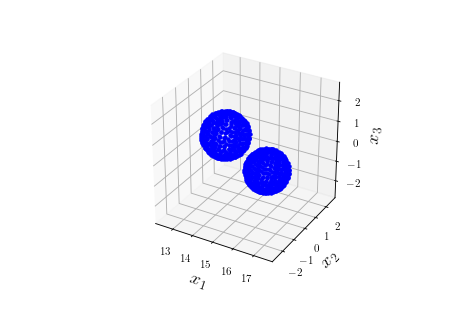

<IPython.core.display.Javascript object>


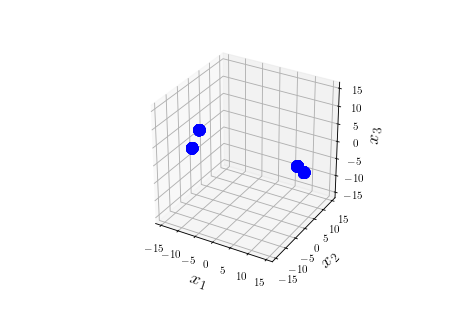

<IPython.core.display.Javascript object>


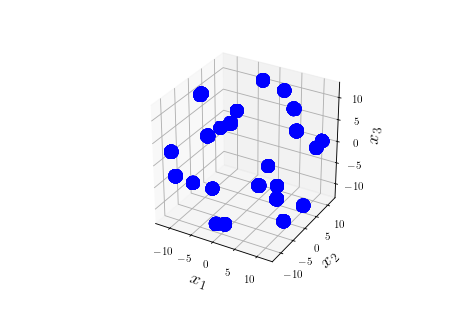

True

In [3]:
%matplotlib notebook
# %matplotlib inline
from src.geo import *
from src import stokes_flow as sf

problem_kwargs = {'dumb_d': 5, 
                  'dumb_theta': np.pi / 4, 
                  'rs': 1, 
                  'ds': 0.2, 
                  'helicoid_r': 15, 
                  'helicoid_ndsk_each': 4, }

dumb_d = problem_kwargs['dumb_d']
dumb_theta = problem_kwargs['dumb_theta']
ds = problem_kwargs['ds']
rs = problem_kwargs['rs']
sphere_geo0 = sphere_geo()
sphere_geo0.create_delta(ds, rs)
sphere_geo1 = sphere_geo0.copy()
sphere_geo0.move(np.array((0, 0, dumb_d / 2)))
sphere_geo1.move(np.array((0, 0, -dumb_d / 2)))
dumb_geo = base_geo()
dumb_geo.combine([sphere_geo0, sphere_geo1], origin=np.zeros(3), geo_norm=np.array((0, 0, 1)))
dumb_geo.node_rotation(norm=np.array((1, 0, 0)), theta=dumb_theta)
dumb_obj1 = sf.StokesFlowObj()
dumb_obj1.set_data(dumb_geo, dumb_geo, 'dumb')
helicoid_r = problem_kwargs['helicoid_r']
dumb_obj1.move(np.array((helicoid_r, 0, 0)))
dumb_obj1.show_u_nodes(linestyle='')

dumb_obj2 = dumb_obj1.copy()
dumb_obj2.node_rotation(norm=np.array((0, 0, 1)), theta=np.pi, rotation_origin=np.zeros(3))
propeller_obj = sf.StokesFlowObj()
propeller_obj.combine((dumb_obj1, dumb_obj2))
propeller_obj.show_u_nodes(linestyle='')

helicoid_comp = creat_helicoid_dumb(**problem_kwargs)
helicoid_comp.show_u_nodes(linestyle='')

In [2]:
problem_kwargs = {'dumb_d': 5, 
                  'dumb_theta': np.pi / 4, 
                  'rs': 1, 
                  'ds': 0.2, 
                  'helicoid_r': 10, 
                  'helicoid_ndsk_each': 4, }
helicoid_comp = creat_helicoid_dumb(**problem_kwargs)

ndsk_each = problem_kwargs['helicoid_ndsk_each']
dumb_theta = problem_kwargs['dumb_theta']
rotM_list = []
rot_dth = 2 * np.pi / ndsk_each
for i0 in range(ndsk_each):
    rot_th = i0 * rot_dth + rot_dth / 2
    tM1 = get_rot_matrix((0, 0, 1), rot_th)
    tM2 = np.dot(get_rot_matrix((1, 0, 0), np.pi / 2), tM1)
    tM3 = np.dot(get_rot_matrix((0, 1, 0), np.pi / 2), tM1)
    rotM_list.append(tM1)
    rotM_list.append(tM2)
    rotM_list.append(tM3)
base_norm = np.dot(get_rot_matrix((1, 0, 0), dumb_theta), (0, 0, 1))
for rotM, tobj in zip(rotM_list, helicoid_comp.get_obj_list()):
    print(np.dot(rotM, base_norm) - tobj.get_u_geo().get_geo_norm())

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]


## Fig. S1

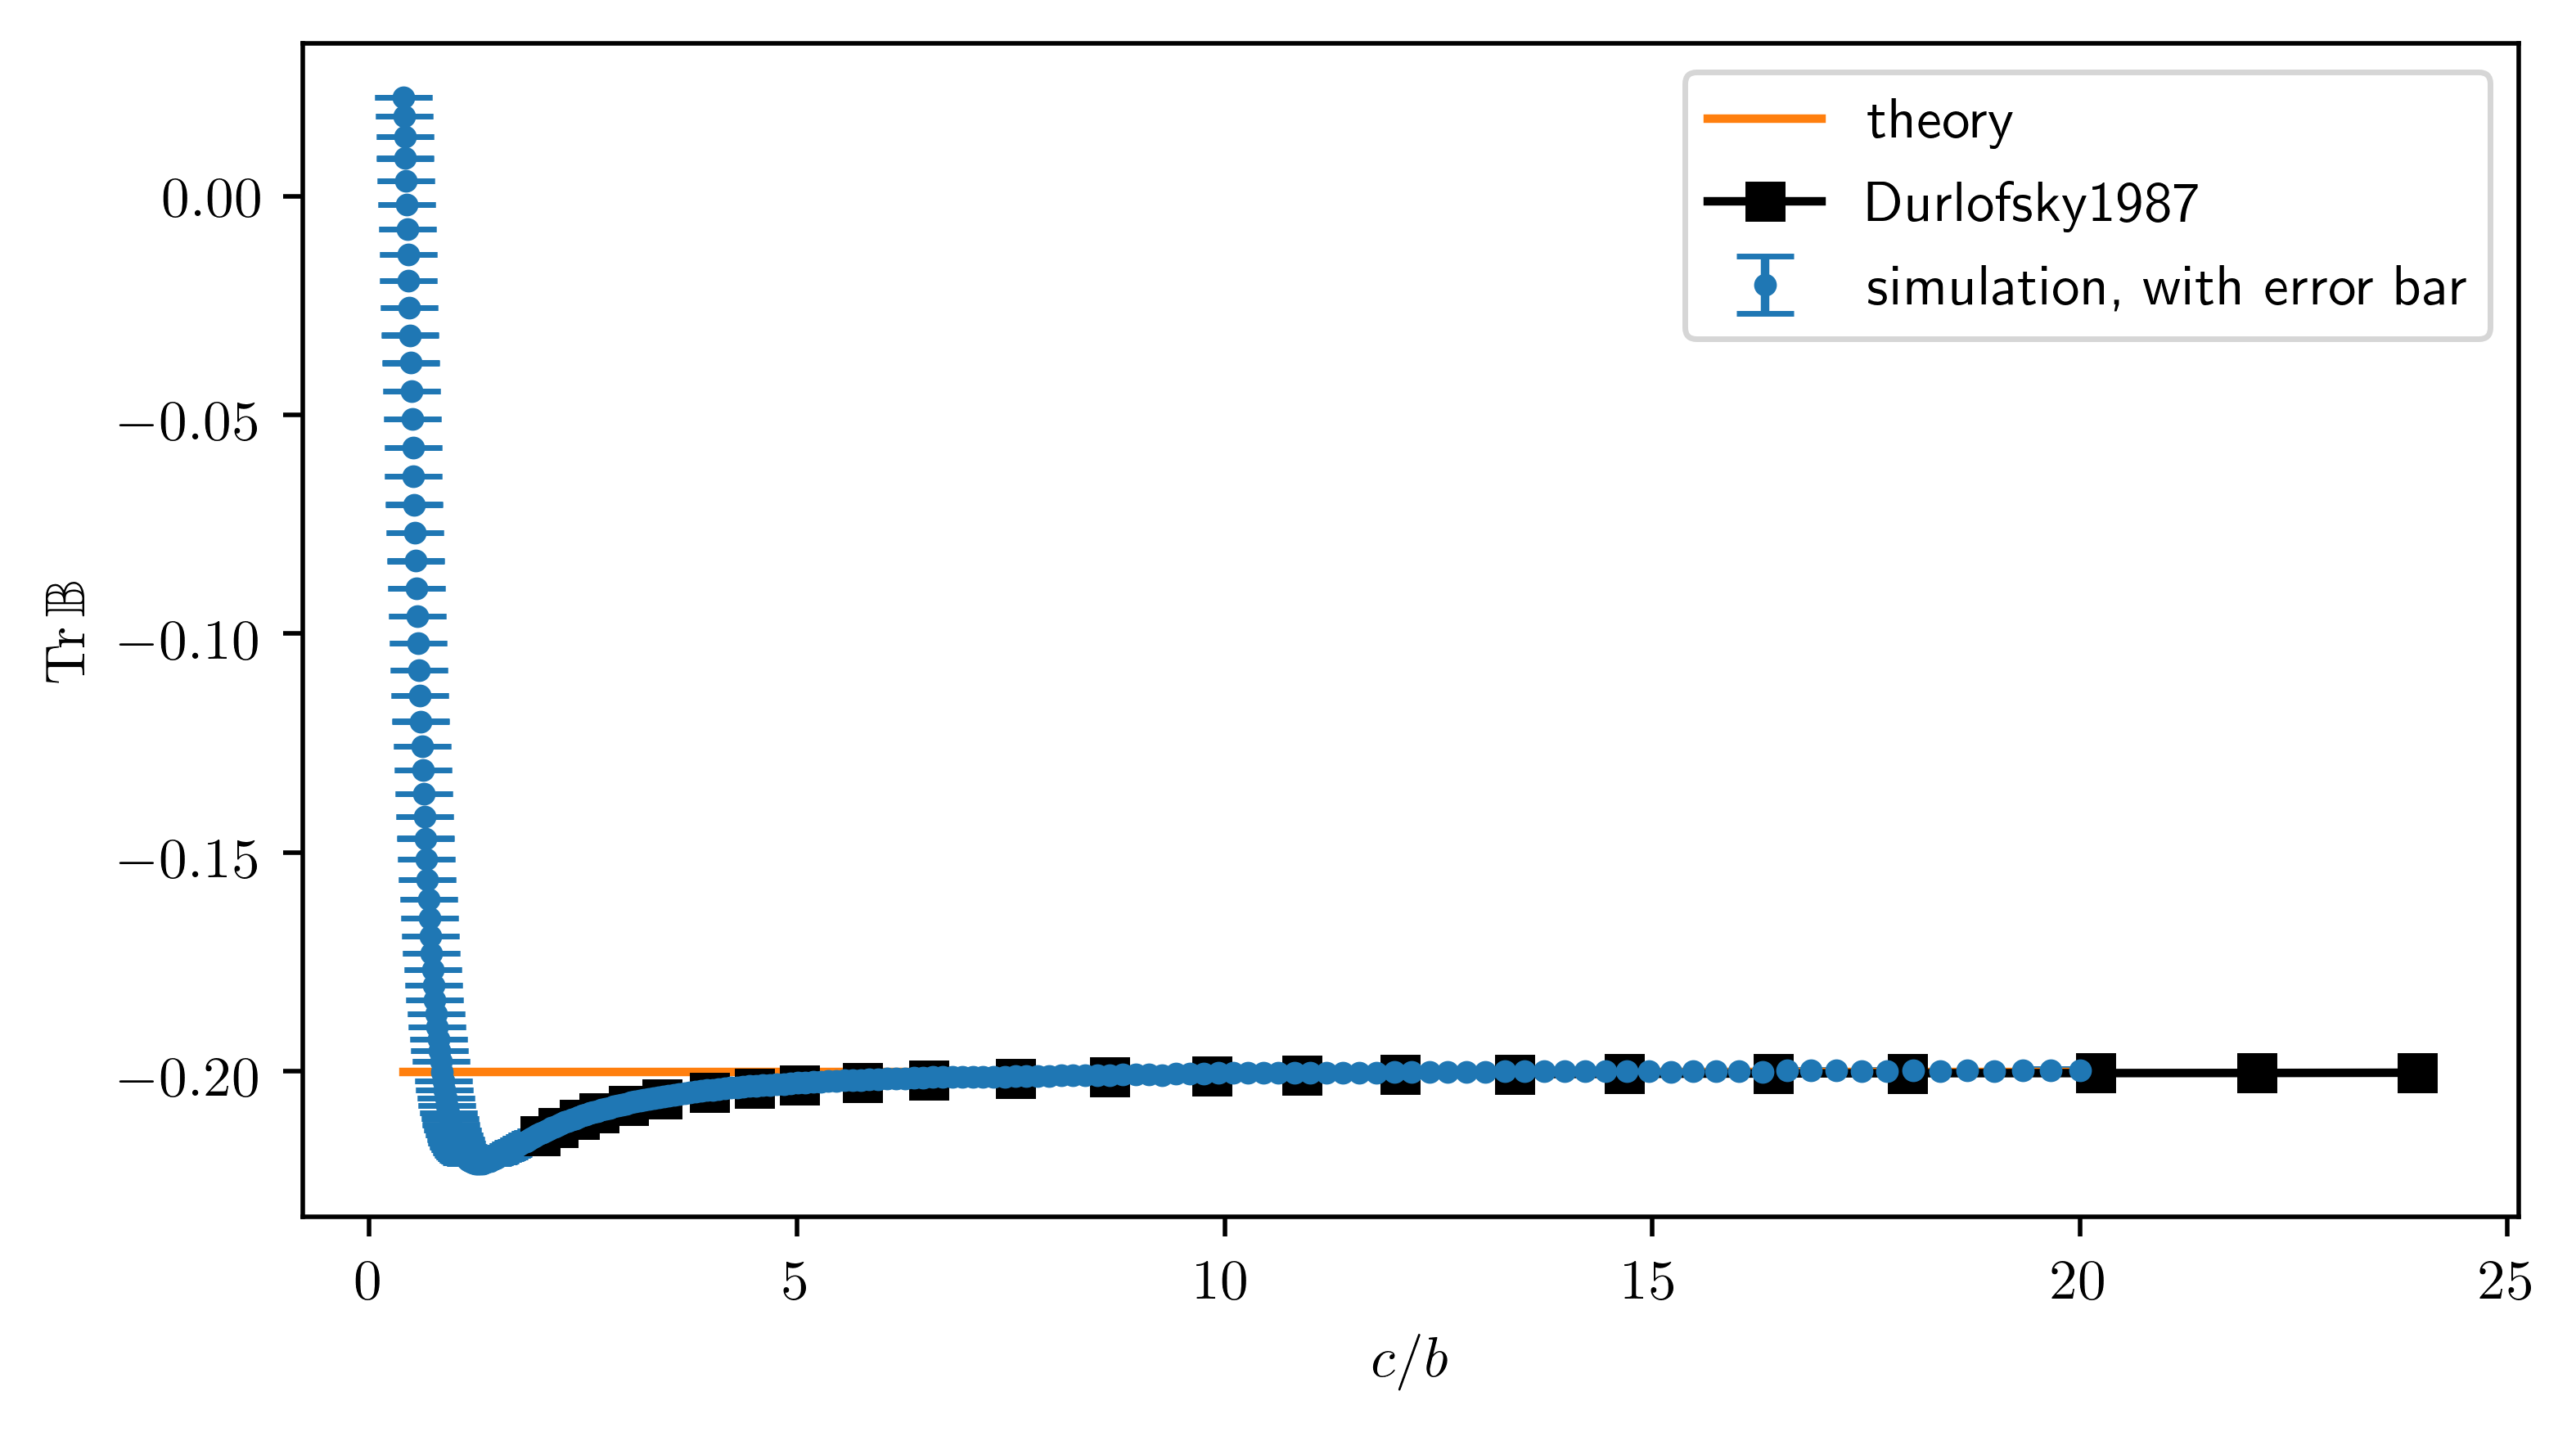

In [4]:
%matplotlib inline 
job_dir = 'twoArmPropeller_fig1_a'
figsize = np.array((16, 9)) * 0.4
dpi = 500
A2_fct = -3.4085
TrB_Durl = np.array([1.9977037887485647, -0.21474774429998308, 
                      2.2043628013777266, -0.21285616270690896, 
                      2.456946039035591, -0.21093462003909763, 
                      2.6865671641791042, -0.20943346331406032, 
                      3.030998851894374, -0.2077522987970749, 
                      3.4213547646383464, -0.20631144347562258, 
                      3.972445464982778, -0.20487082949769517, 
                      4.500574052812858, -0.20391066152260182, 
                      5.0287026406429405, -0.20322076381777873, 
                      5.763490241102183, -0.20253117641177343, 
                      6.5442020665901275, -0.2020218381412411, 
                      7.5545350172215855, -0.2016029347372631, 
                      8.656716417910449, -0.20127425933396081, 
                      9.850746268656714, -0.2010358119313343, 
                      10.907003444316878, -0.20088724775291938, 
                      12.055109070034444, -0.20076885151512017, 
                      13.38691159586682, -0.2006507310984923, 
                      14.672789896670494, -0.20059260178663163, 
                      16.417910447761194, -0.2005051319976693, 
                      17.979334098737088, -0.20044741641756567, 
                      20.18369690011481, -0.20042069624159176, 
                      22.066590126291622, -0.200393493378568, 
                      23.94948335246843, -0.2003362604855142, ]).reshape(-1, 2)

problem_kwarg_list, At_list, Bt1_list, Bt2_list, Ct_list = load_AtBtCt(job_dir)
dumb_d = problem_kwarg_list[0]['dumb_d']
dumb_theta = problem_kwarg_list[0]['dumb_theta']
# phi_darci = (-dumb_theta + np.pi / 2) % np.pi
phi_darci = dumb_theta
A2 = A2_fct * problem_kwarg_list[0]['rs']
TrB_darci = (A2 ** 2 * np.sin(4 * phi_darci)) / (16 * np.pi)
# print(dumb_theta, phi_darci)
helicoid_r_list = []
TrBt1_list = []
TrBt2_list = []
for problem_kwarg, Bt1, Bt2 in zip(problem_kwarg_list, Bt1_list, Bt2_list):
    helicoid_r = problem_kwarg['helicoid_r']
    TrBt1 = np.trace(Bt1)
    TrBt2 = np.trace(Bt2)
    helicoid_r_list.append(helicoid_r)
    TrBt1_list.append(TrBt1)
    TrBt2_list.append(TrBt2)
helicoid_r_list = np.hstack(helicoid_r_list)
tidx = np.argsort(helicoid_r_list)
helicoid_r_list = helicoid_r_list[tidx]
TrBt1_list = np.hstack(TrBt1_list)[tidx]
TrBt2_list = np.hstack(TrBt2_list)[tidx]
TrBt_mean = np.mean((TrBt1_list, TrBt2_list), axis = 0)
TrBt_std = np.std((TrBt1_list, TrBt2_list), axis = 0)

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
# axi.semilogx(helicoid_r_list / dumb_d, TrBt1_list, '.', 
#              label='$\\Tr \\mathbb{B}_{sim,force}$')
# axi.semilogx(helicoid_r_list / dumb_d, TrBt2_list, '.', 
#              label='$\\Tr \\mathbb{B}_{sim,torque}$')
axi.errorbar(helicoid_r_list / dumb_d, TrBt_mean, yerr=TrBt_std, fmt='.', 
             capsize=5, label='simulation, with error bar')
axi.plot(helicoid_r_list / dumb_d, TrB_darci * np.ones_like(helicoid_r_list), '-', label='theory')
axi.plot(TrB_Durl[:, 0], TrB_Durl[:, 1], '-sk', label='Durlofsky1987')
axi.legend()
# axi.set_xlabel('$r_1/d_d$')
axi.set_xlabel('$c/b$')
axi.set_ylabel('$\\Tr \mathbb{B}$')
plt.tight_layout()


(116,)

## SM, Eq. 21, wrong, archive

In [4]:
job_dir_list = ['Collins2020_smFig1_c', 
                'Collins2020_smFig1_b', 
                'Collins2020_smFig1_a', 
                'Collins2020_smFig1_d', 
                'Collins2020_smFig1_e', 
                'Collins2020_smFig1_f', 
                'Collins2020_smFig1_g', ]
figsize = np.array((16, 9)) * 0.5
dpi = 100

dumb_theta_list = []
TrB1_list_list = []
TrB2_list_list = []
helicoid_r_list_list = []
for job_dir in job_dir_list:
    problem_kwarg_list, At_list, Bt1_list, Bt2_list, Ct_list = load_AtBtCt(job_dir)
    helicoid_r_list = []
    TrBt1_list = []
    TrBt2_list = []
    for problem_kwarg, Bt1, Bt2 in zip(problem_kwarg_list, Bt1_list, Bt2_list):
        helicoid_r = problem_kwarg['helicoid_r']
        TrBt1 = np.trace(Bt1)
        TrBt2 = np.trace(Bt2)
        helicoid_r_list.append(helicoid_r)
        TrBt1_list.append(TrBt1)
        TrBt2_list.append(TrBt2)
    helicoid_r_list = np.hstack(helicoid_r_list)
    tidx = np.argsort(helicoid_r_list)
    helicoid_r_list = helicoid_r_list[tidx]
    TrBt1_list = np.hstack(TrBt1_list)[tidx]
    TrBt2_list = np.hstack(TrBt2_list)[tidx]
    
    dumb_theta_list.append(problem_kwarg['dumb_theta'])
    TrB1_list_list.append(TrBt1_list)
    TrB2_list_list.append(TrBt2_list)
    helicoid_r_list_list.append(helicoid_r_list)
dumb_theta_list = np.array(dumb_theta_list)
TrB2_list_list = np.array(TrB2_list_list)
TrB1_list_list = np.array(TrB1_list_list)
helicoid_r_list_list = np.array(helicoid_r_list_list)

In [5]:
helicoid_r_list_list[0]

array([   5.      ,   10.      ,   15.      ,   20.      ,   25.      ,
         30.      ,   35.      ,   40.      ,   45.      ,   50.      ,
         58.605115,   68.69119 ,   80.513101,   94.369591,  110.610815,
        129.64719 ,  151.959769,  178.112395,  208.765947,  244.695046,
        286.807626,  336.167877,  394.023141,  461.835429,  541.318367,
        634.480502,  743.676054,  871.664411, 1021.679859, 1197.51331 ,
       1403.608102, 1645.172281, 1928.310211, 2260.176828, 2649.158453,
       3105.084709, 3639.476922, 4265.839262, 5000.      ])

Text(0, 0.5, '$\\Tr \\mathbb{B}$')

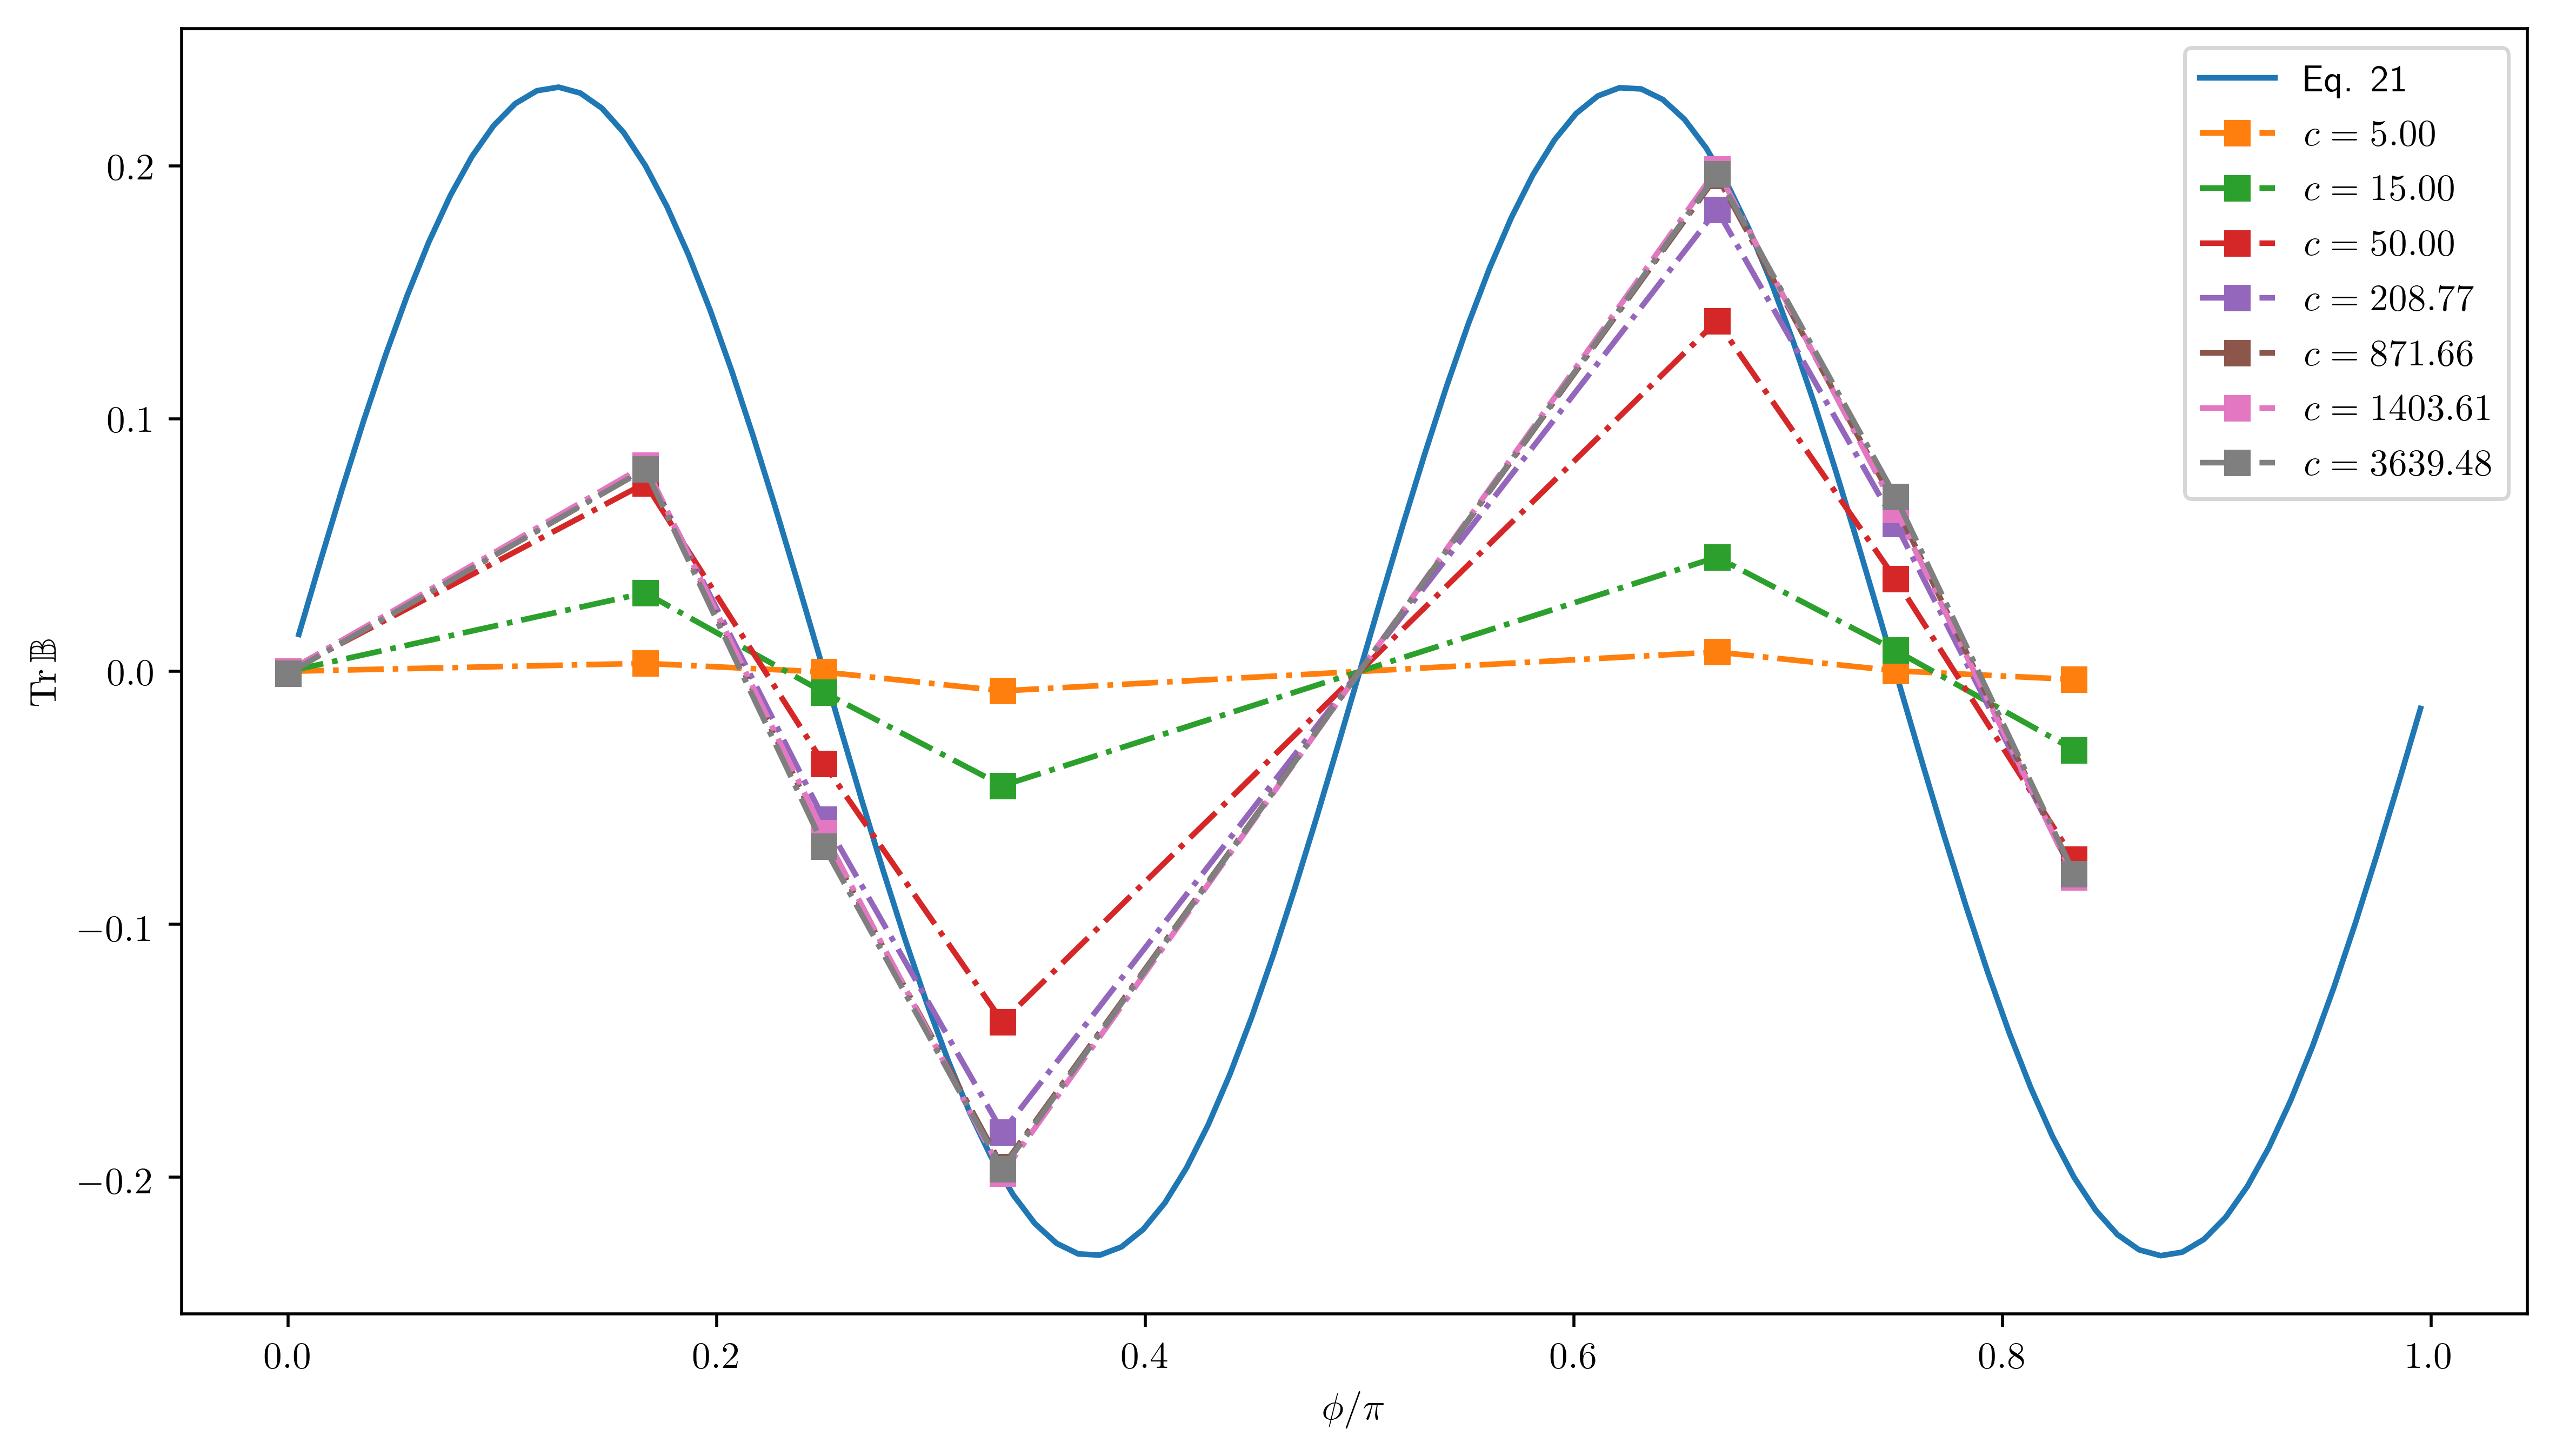

In [98]:
%matplotlib inline 
assert 1 == 2

dumb_r = 1
phi = np.linspace(0, np.pi, 100)
A2 = -3.4085 * dumb_r
figsize = np.array((16, 9)) * 0.7
dpi = 500
plt_r_idx = [0, 2, 9, 18, 27, 30, 36]


phi_darci = (-phi + np.pi / 2) % np.pi
TrB_darci = (A2 ** 2 * np.sin(4 * phi_darci)) / (16 * np.pi)
dumb_theta_list_darci = (-dumb_theta_list + np.pi / 2) % np.pi

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
tidx = np.argsort(phi_darci)
axi.plot(phi_darci[tidx] / np.pi, TrB_darci[tidx], '-', label='Eq. 21')

t1 = np.vstack(TrB1_list_list).T
t2 = np.vstack(TrB2_list_list).T
tidx = np.argsort(dumb_theta_list_darci)
for i0 in plt_r_idx:
    TrB1_list = t1[i0]
    TrB2_list = t2[i0]
    tc = helicoid_r_list_list[0][i0]
    axi.plot(dumb_theta_list_darci[tidx] / np.pi, TrB1_list[tidx], '-.s', label='$c=%.2f$' % tc)
axi.legend()
axi.set_xlabel('$\\phi / \\pi$')
axi.set_ylabel('$\\Tr \\mathbb{B}$')


## Helicoid_dumb, vary helicoid_r and dumb_theta at the same time

In [23]:
%matplotlib inline
# job_dir = 'Collins2020_smFig1_all_1'
job_dir = 'Collins2020_smFig1_all_2'
min_helicoid_r = 10

problem_kwarg_list, At_list, Bt1_list, Bt2_list, Ct_list = load_AtBtCt(job_dir)
helicoid_r_list = np.array([problem_kwarg['helicoid_r'] for problem_kwarg in problem_kwarg_list])
dumb_theta_list = np.array([problem_kwarg['dumb_theta'] for problem_kwarg in problem_kwarg_list])
TrB1_list = np.array([np.trace(Bt1) for Bt1 in Bt1_list])
TrB2_list = np.array([np.trace(Bt2) for Bt2 in Bt2_list])
TrA_list = np.array([np.trace(At) for At in At_list])

tidx = helicoid_r_list >= min_helicoid_r
data_dumb = pd.DataFrame({'TrB1': TrB1_list[tidx], 
                          'TrB2': TrB2_list[tidx], 
                          'TrA': TrA_list[tidx],                          
                          'dumb_theta': dumb_theta_list[tidx], 
                          'helicoid_r': helicoid_r_list[tidx], 
                         }).pivot_table(index=['dumb_theta'], columns=['helicoid_r'], )


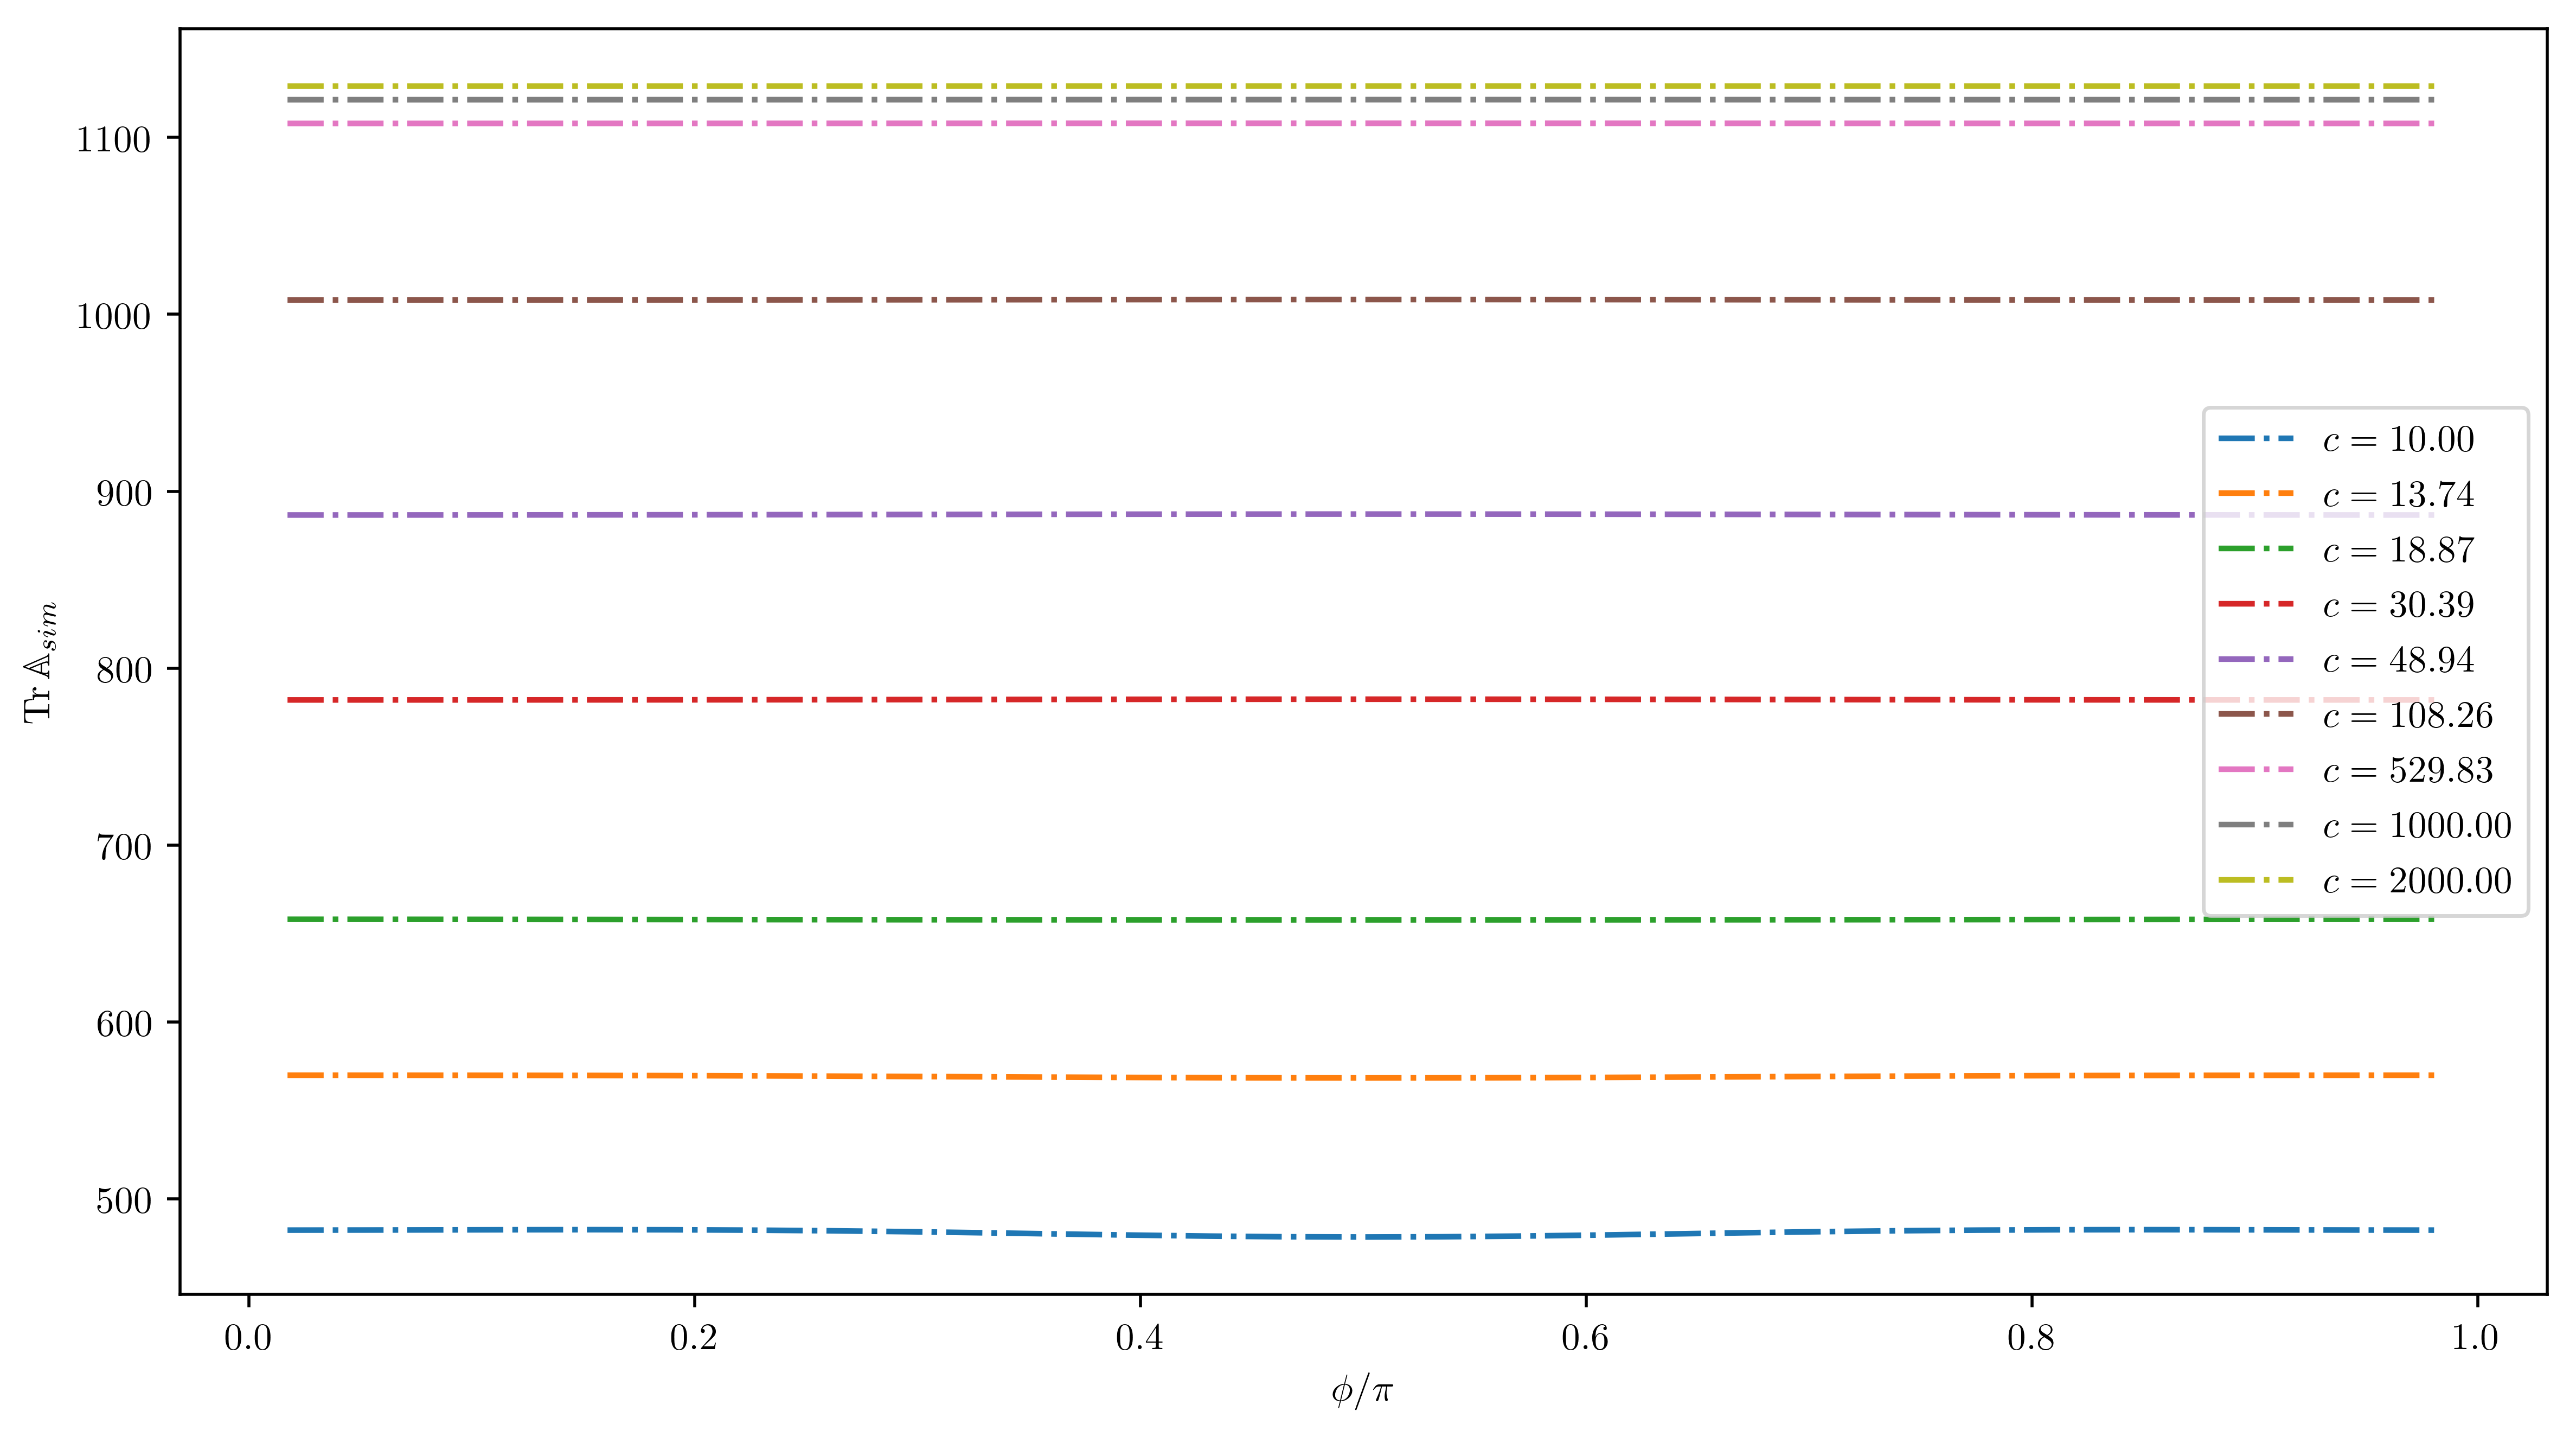

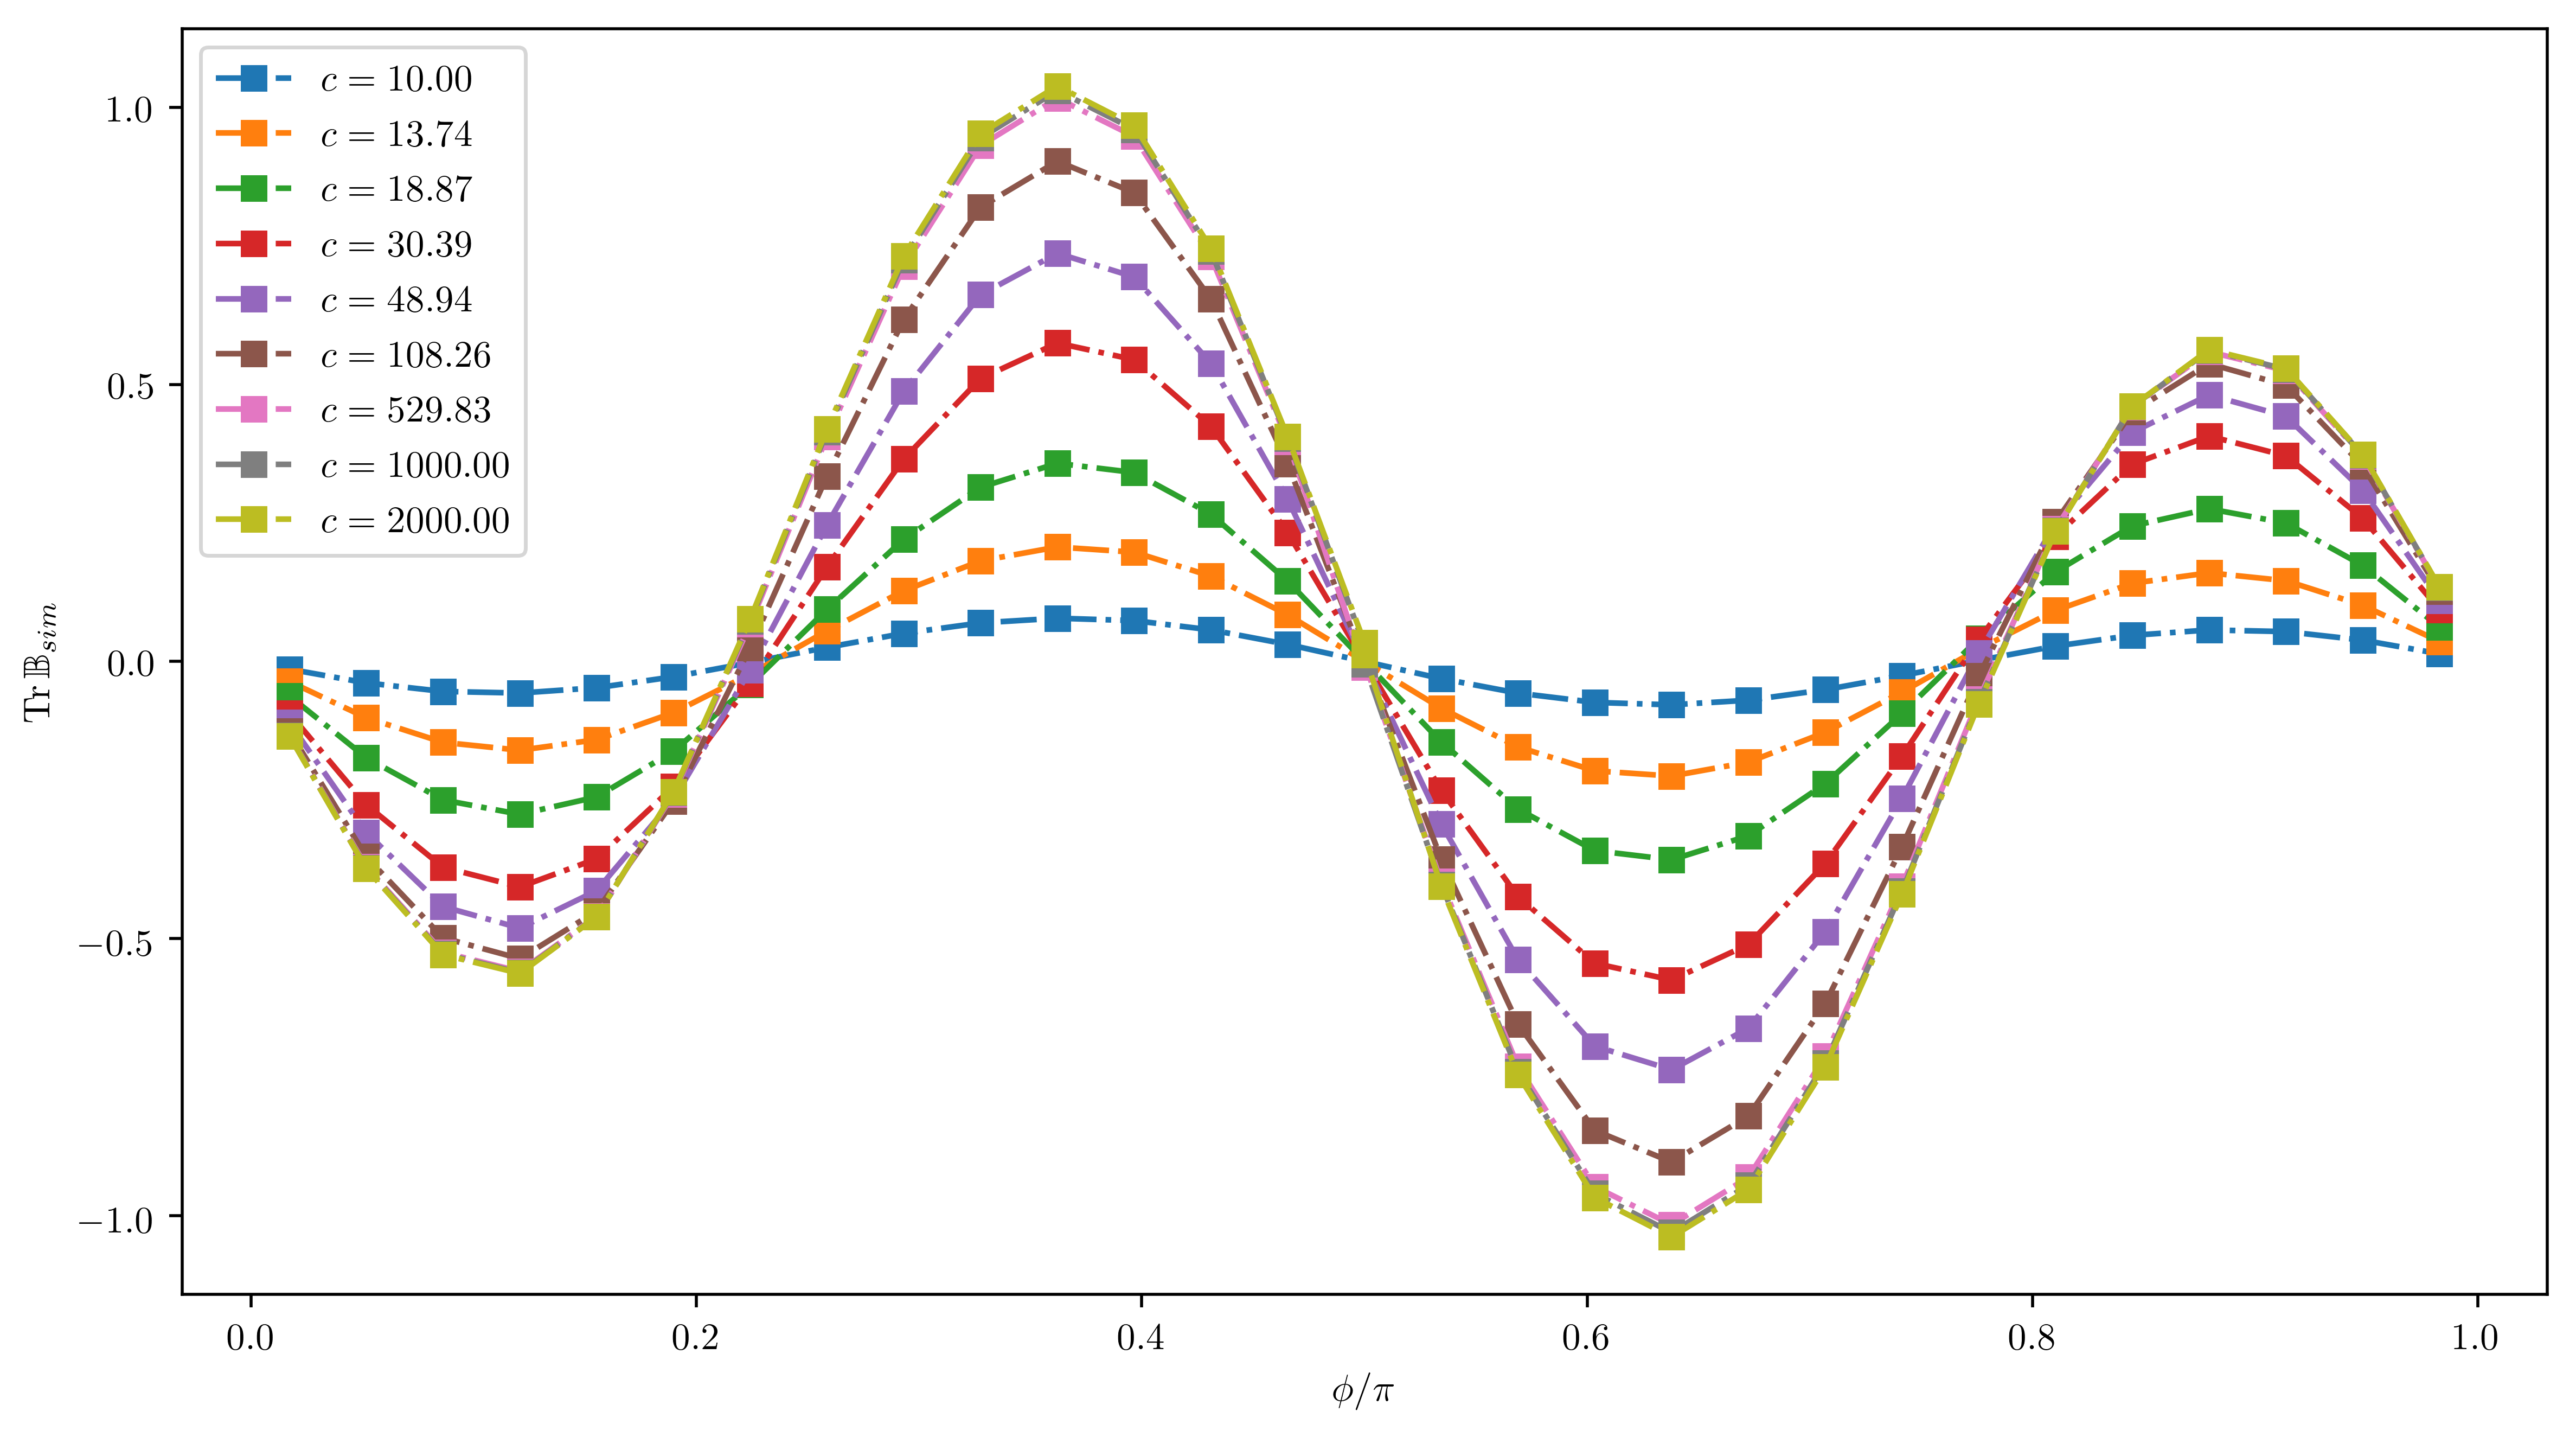

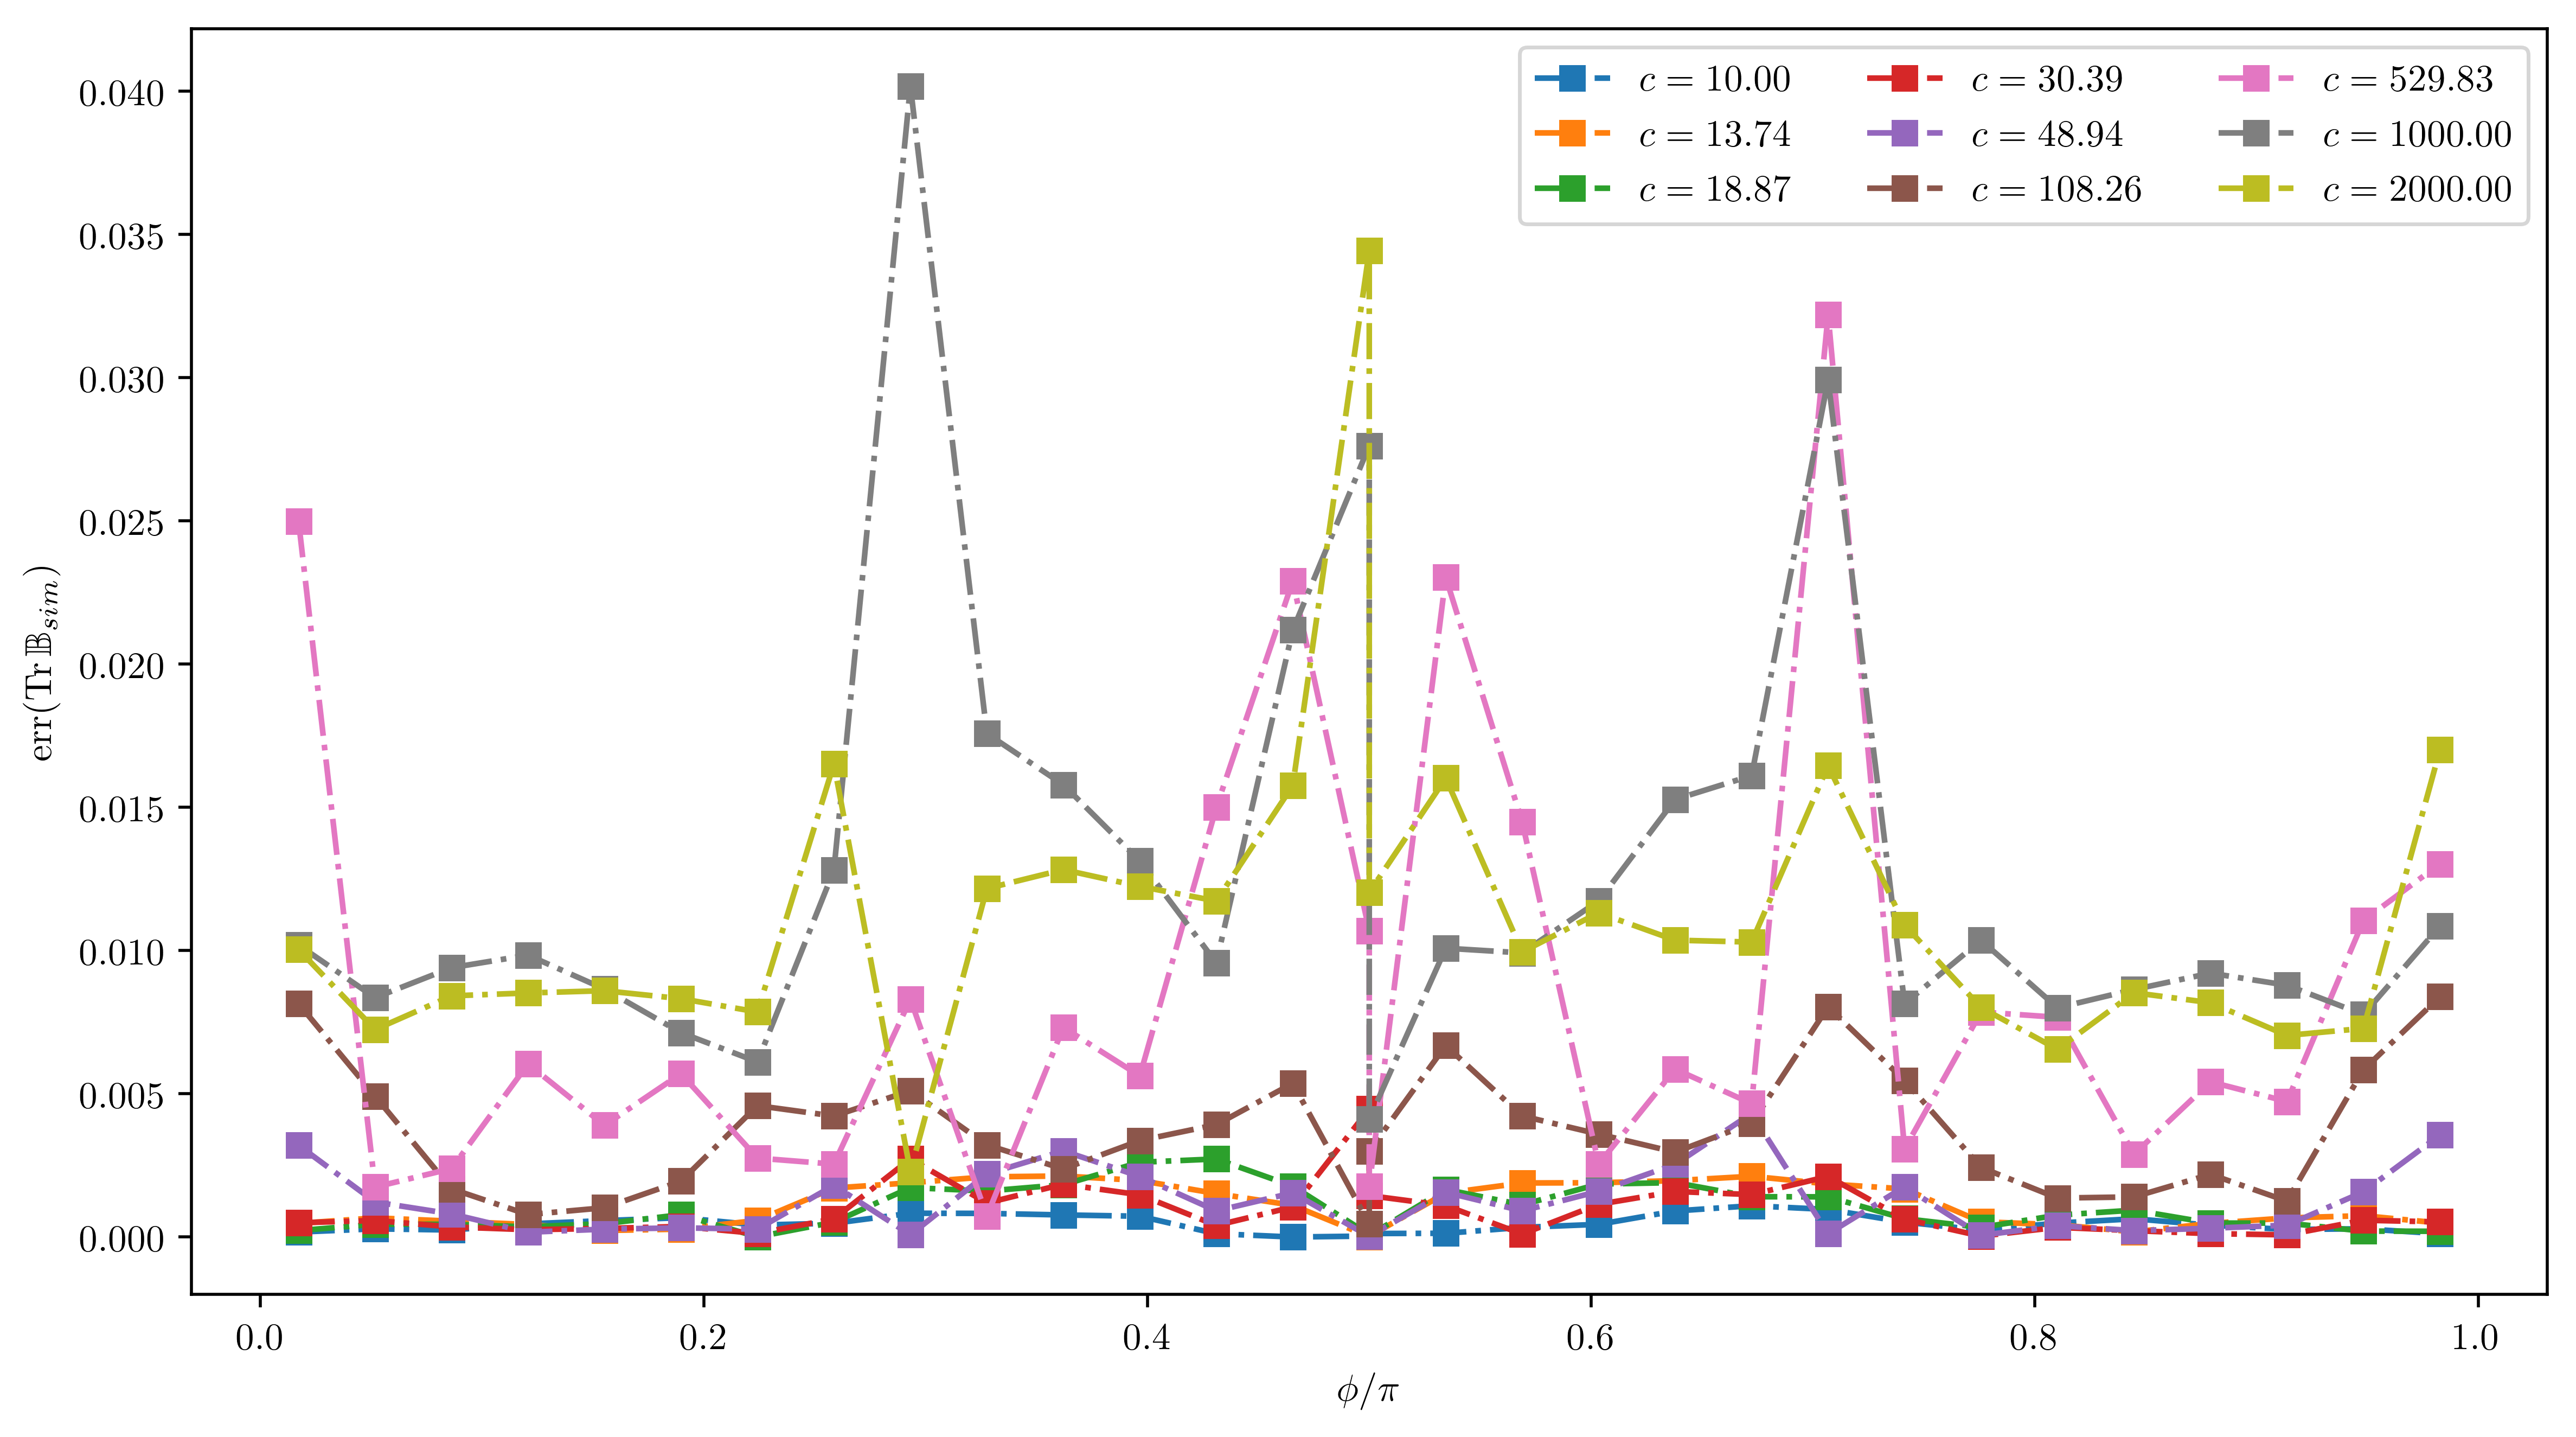

In [28]:
figsize = np.array((16, 9)) * 0.6
dpi = 500
useTrB = data_dumb.TrB2
plt_r_idx = [0, 2, 4, 7, 10, 15, 25, 29, 31]
ri_list = useTrB.columns.values

# TrA, simulation vs theory
fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
for ri in ri_list[plt_r_idx]:
    tTrB = data_dumb.TrA[ri]
    dumb_theta_list = tTrB.index.values
    ty = tTrB.values
    dumb_theta_list_darci = (dumb_theta_list + np.pi / 2) % np.pi
#     dumb_theta_list_darci = dumb_theta_list
    tidx = np.argsort(dumb_theta_list_darci)
    axi.plot(dumb_theta_list_darci[tidx] / np.pi, ty[tidx], '-.', label='$c=%.2f$' % ri)
axi.legend()
axi.set_xlabel('$\\phi / \\pi$')
axi.set_ylabel('$\\Tr \\mathbb{A}_{sim}$')
plt.tight_layout()

# TrB, simulation vs theory
fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
for ri in ri_list[plt_r_idx]:
    tTrB = useTrB[ri]
    dumb_theta_list = tTrB.index.values
    ty = tTrB.values
    dumb_theta_list_darci = (dumb_theta_list + np.pi / 2) % np.pi
#     dumb_theta_list_darci = dumb_theta_list
    tidx = np.argsort(dumb_theta_list_darci)
    axi.plot(dumb_theta_list_darci[tidx] / np.pi, ty[tidx], '-.s', label='$c=%.2f$' % ri)
# # dbg
# axi.plot(1/4, 0.3375, 'o', label='0.3375')
axi.legend(loc='upper left')
axi.set_xlabel('$\\phi / \\pi$')
axi.set_ylabel('$\\Tr \\mathbb{B}_{sim}$')
plt.tight_layout()

# abs err of TrB
fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
for ri in ri_list[plt_r_idx]:
    tTrB1 = data_dumb.TrB1[ri]
    tTrB2 = data_dumb.TrB2[ri]
    errTrB = np.abs(tTrB1 - tTrB2)
    dumb_theta_list = errTrB.index.values
    ty = errTrB.values
    dumb_theta_list_darci = (dumb_theta_list + np.pi / 2) % np.pi
#     dumb_theta_list_darci = dumb_theta_list
    tidx = np.argsort(dumb_theta_list_darci)
    axi.plot(dumb_theta_list_darci[tidx] / np.pi, ty[tidx], '-.s', label='$c=%.2f$' % ri)
axi.legend(ncol=3)
axi.set_xlabel('$\\phi / \\pi$')
axi.set_ylabel('$\operatorname{err}(\\Tr \\mathbb{B}_{sim})$')
plt.tight_layout()
    

## Fig. 3 (b)

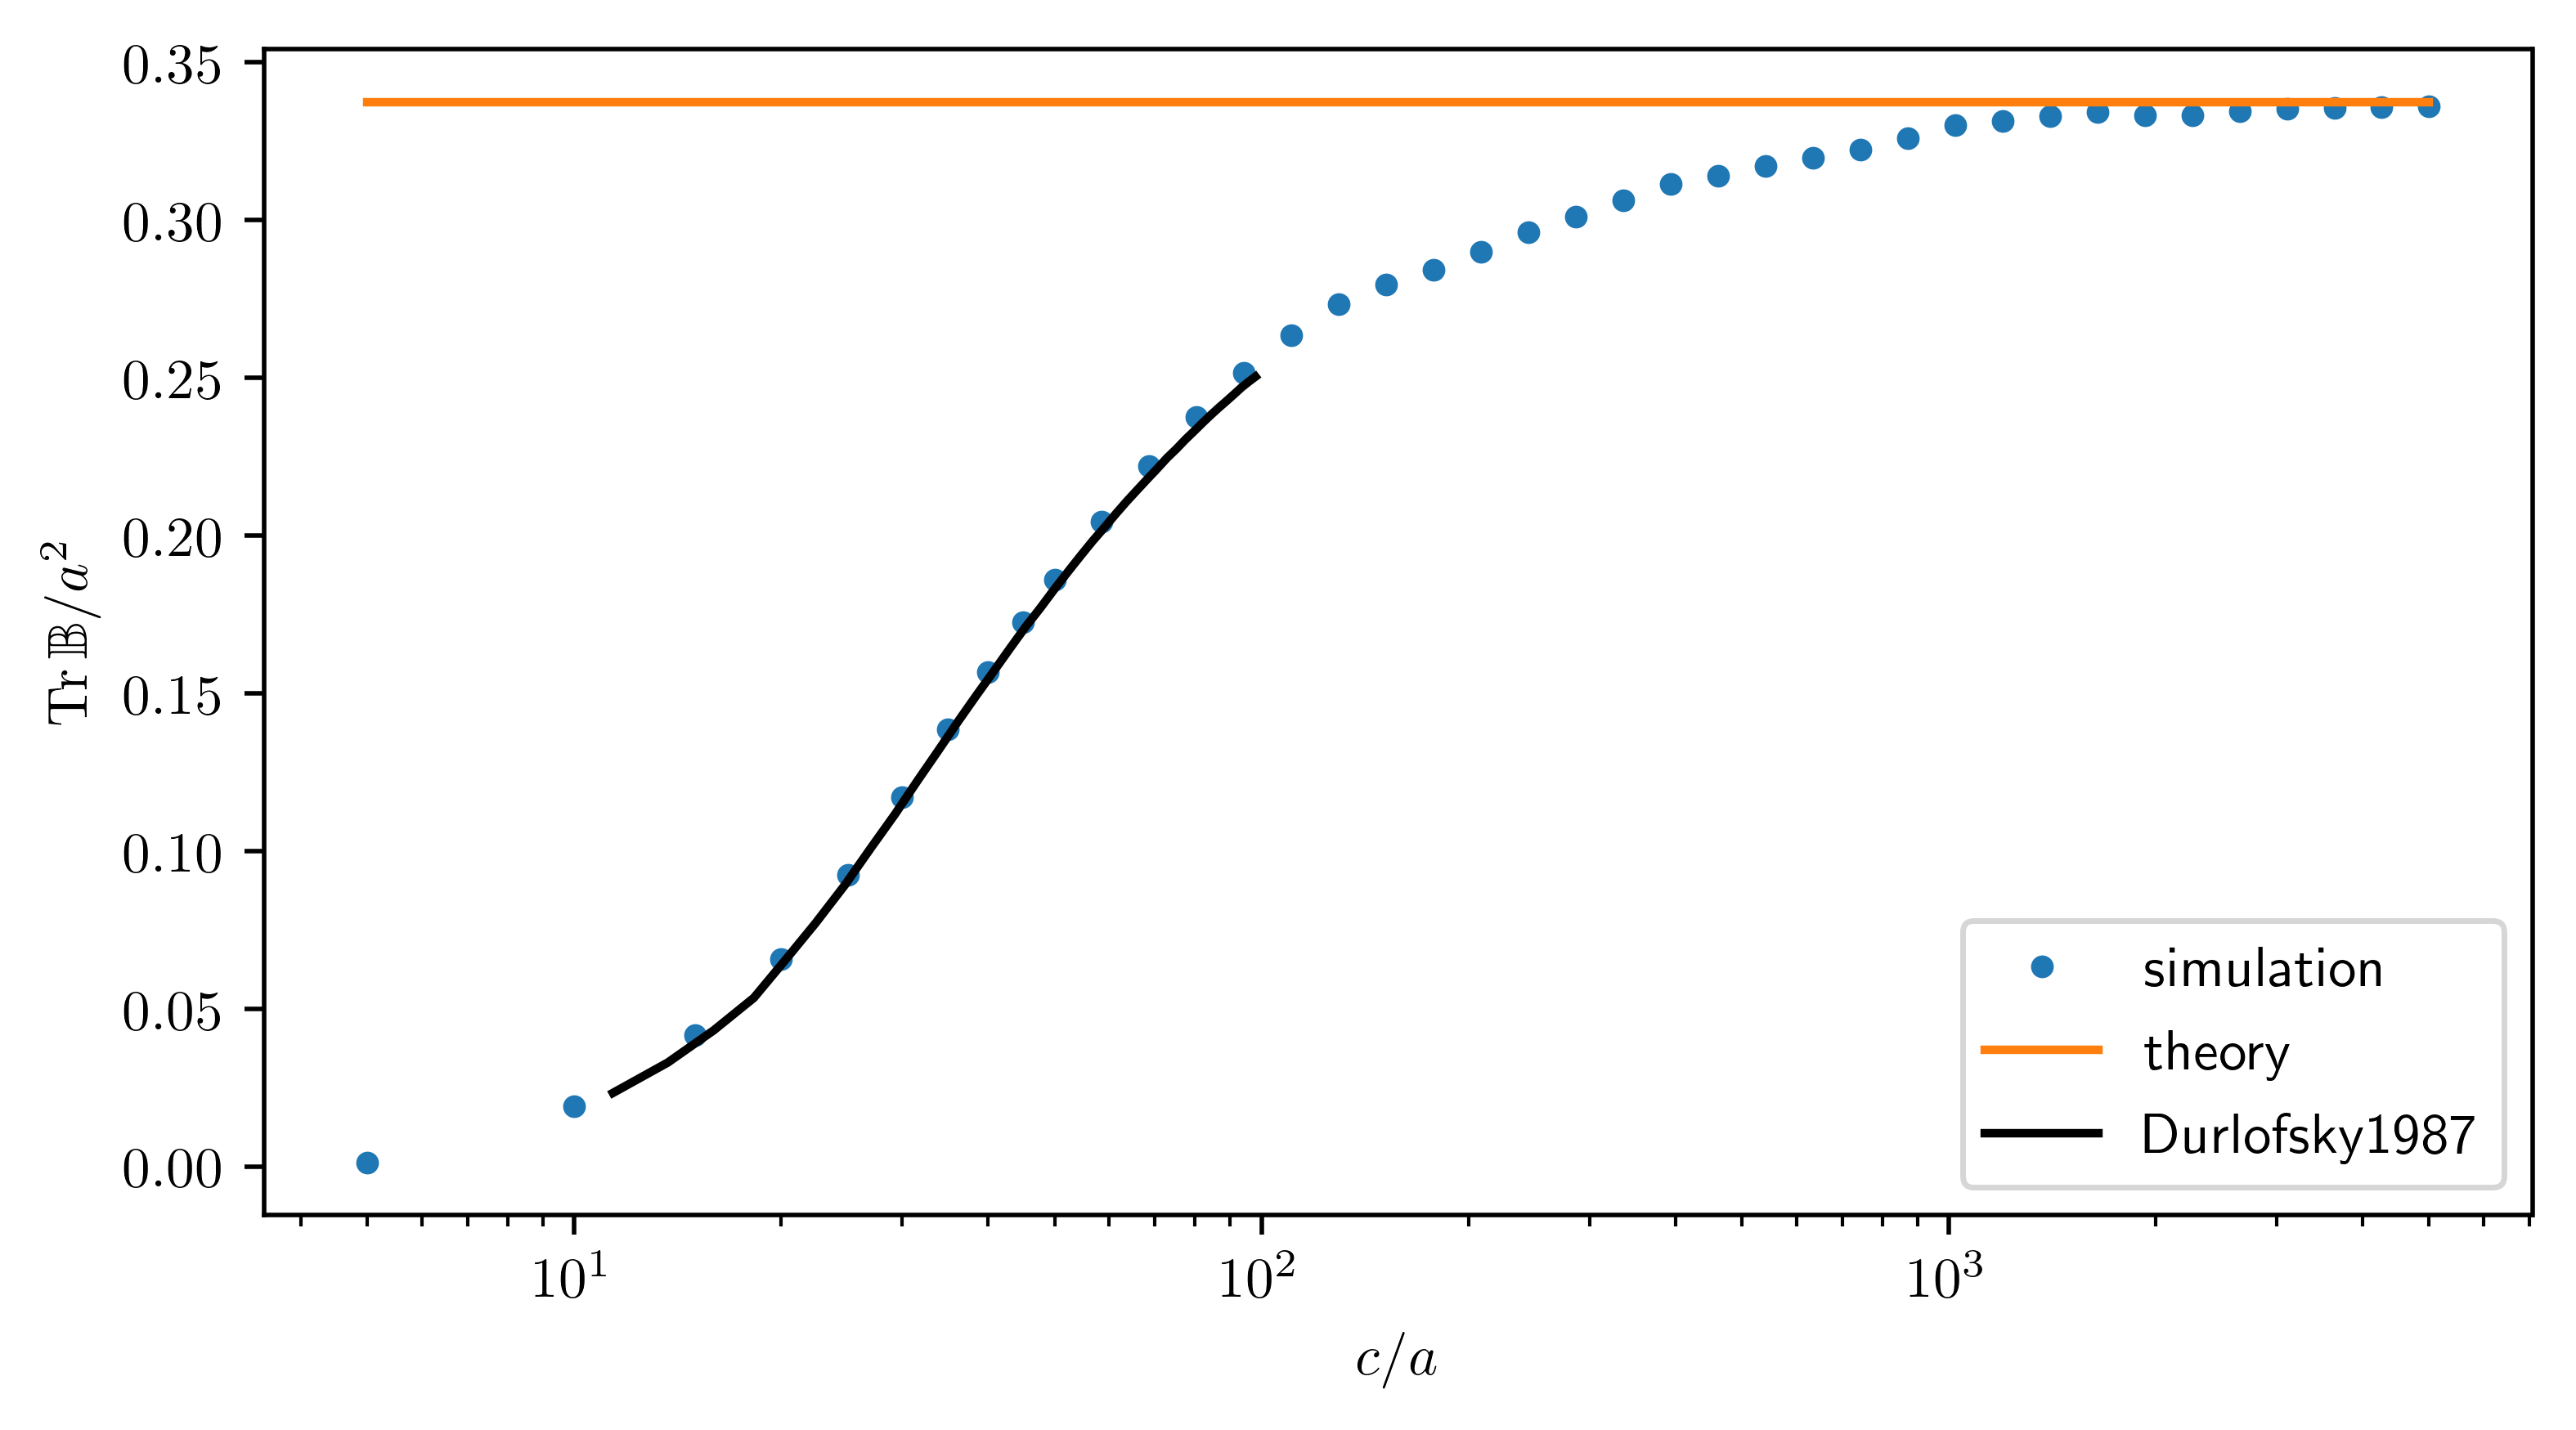

In [3]:
%matplotlib inline 
job_dir = 'Collins2020_smFig1_f2'
figsize = np.array((16, 9)) * 0.4
dpi = 500
theory_Darci2020 = 0.3375
TrB_Durl = np.array((11.388380989411132, 0.02333238765469392, 
            13.678572698271523, 0.03293491735783438, 
            15.967962659640591, 0.0431996904887777, 
            18.257352621009687, 0.0534644636197209, 
            20.35239899049091, 0.06581530354824305, 
            22.448688068583607, 0.07713966616367085, 
            24.73607366122448, 0.08906004786412103, 
            27.023459253865354, 0.10098042956457132, 
            29.312247904615987, 0.11174188526636675, 
            31.60123699223948, 0.12233778011121144, 
            33.89142870109984, 0.1319403098143519, 
            36.182221720578696, 0.14104615694664036, 
            38.474016924421676, 0.14932419979417522, 
            40.766613875755866, 0.15693999921390733, 
            43.059611700835774, 0.16422467691973797, 
            45.35321083653412, 0.1710126720547167, 
            47.647812156596615, 0.17697286290494185, 
            49.942413476659056, 0.18293305375516689, 
            52.23761610733999, 0.18839656203454003, 
            54.53321961176658, 0.19352894860001157, 
            56.829223989938725, 0.19833021345158186, 
            59.125829678729474, 0.20263479573230003, 
            61.42243536752011, 0.2069393780130181, 
            63.71944193005646, 0.2109128385798349, 
            66.01684936633836, 0.21455517743275032, 
            68.31445723949315, 0.218031955428715, 
            70.61226554952083, 0.22134317256772895, 
            72.91007385954839, 0.2246543897067429, 
            75.2084834801945, 0.22746892427490473, 
            77.50669266396773, 0.2304490197000173, 
            79.80530272148661, 0.2330979934112285, 
            82.10391277900555, 0.23574696712243964, 
            84.40272327339721, 0.23823037997670016, 
            86.70173420466176, 0.24054823197400987, 
            89.00094557279908, 0.24270052311436902, 
            91.30015694093646, 0.24485281425472805, 
            93.59936830907384, 0.24700510539508713, 
            95.89898055095682, 0.2488262748215448, 
            98.00709540454602, 0.25038254687688133, )).reshape(-1, 2)

problem_kwarg_list, At_list, Bt1_list, Bt2_list, Ct_list = load_AtBtCt(job_dir)
dumb_d = problem_kwarg_list[0]['dumb_d']
dumb_theta = problem_kwarg_list[0]['dumb_theta']
# phi_darci = (-dumb_theta + np.pi / 2) % np.pi
phi_darci = dumb_theta
# print(dumb_theta, phi_darci)
helicoid_r_list = []
TrBt1_list = []
TrBt2_list = []
for problem_kwarg, Bt1, Bt2 in zip(problem_kwarg_list, Bt1_list, Bt2_list):
    helicoid_r = problem_kwarg['helicoid_r']
    TrBt1 = np.trace(Bt1)
    TrBt2 = np.trace(Bt2)
    helicoid_r_list.append(helicoid_r)
    TrBt1_list.append(TrBt1)
    TrBt2_list.append(TrBt2)
helicoid_r_list = np.hstack(helicoid_r_list)
tidx = np.argsort(helicoid_r_list)
helicoid_r_list = helicoid_r_list[tidx]
TrBt1_list = np.hstack(TrBt1_list)[tidx]
TrBt2_list = np.hstack(TrBt2_list)[tidx]
# TrBt_mean = np.mean((TrBt1_list, TrBt2_list), axis = 0)
TrBt_mean = TrBt1_list
TrBt_std = np.std((TrBt1_list, TrBt2_list), axis = 0)

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi.plot(helicoid_r_list, TrBt_mean, '.', label='simulation')
axi.plot(helicoid_r_list, theory_Darci2020 * np.ones_like(helicoid_r_list), 
         '-', label='theory')
axi.plot(TrB_Durl[:, 0], TrB_Durl[:, 1], '-k', label='Durlofsky1987')
axi.legend()
axi.set_xlabel('$c / a$')
axi.set_ylabel('$\\Tr \mathbb{B} / a$')
axi.set_ylabel('$\\Tr \mathbb{B} / a^2$')
axi.set_xscale('log')
# axi.set_yscale('log')
plt.tight_layout()

## A_1 and A_2

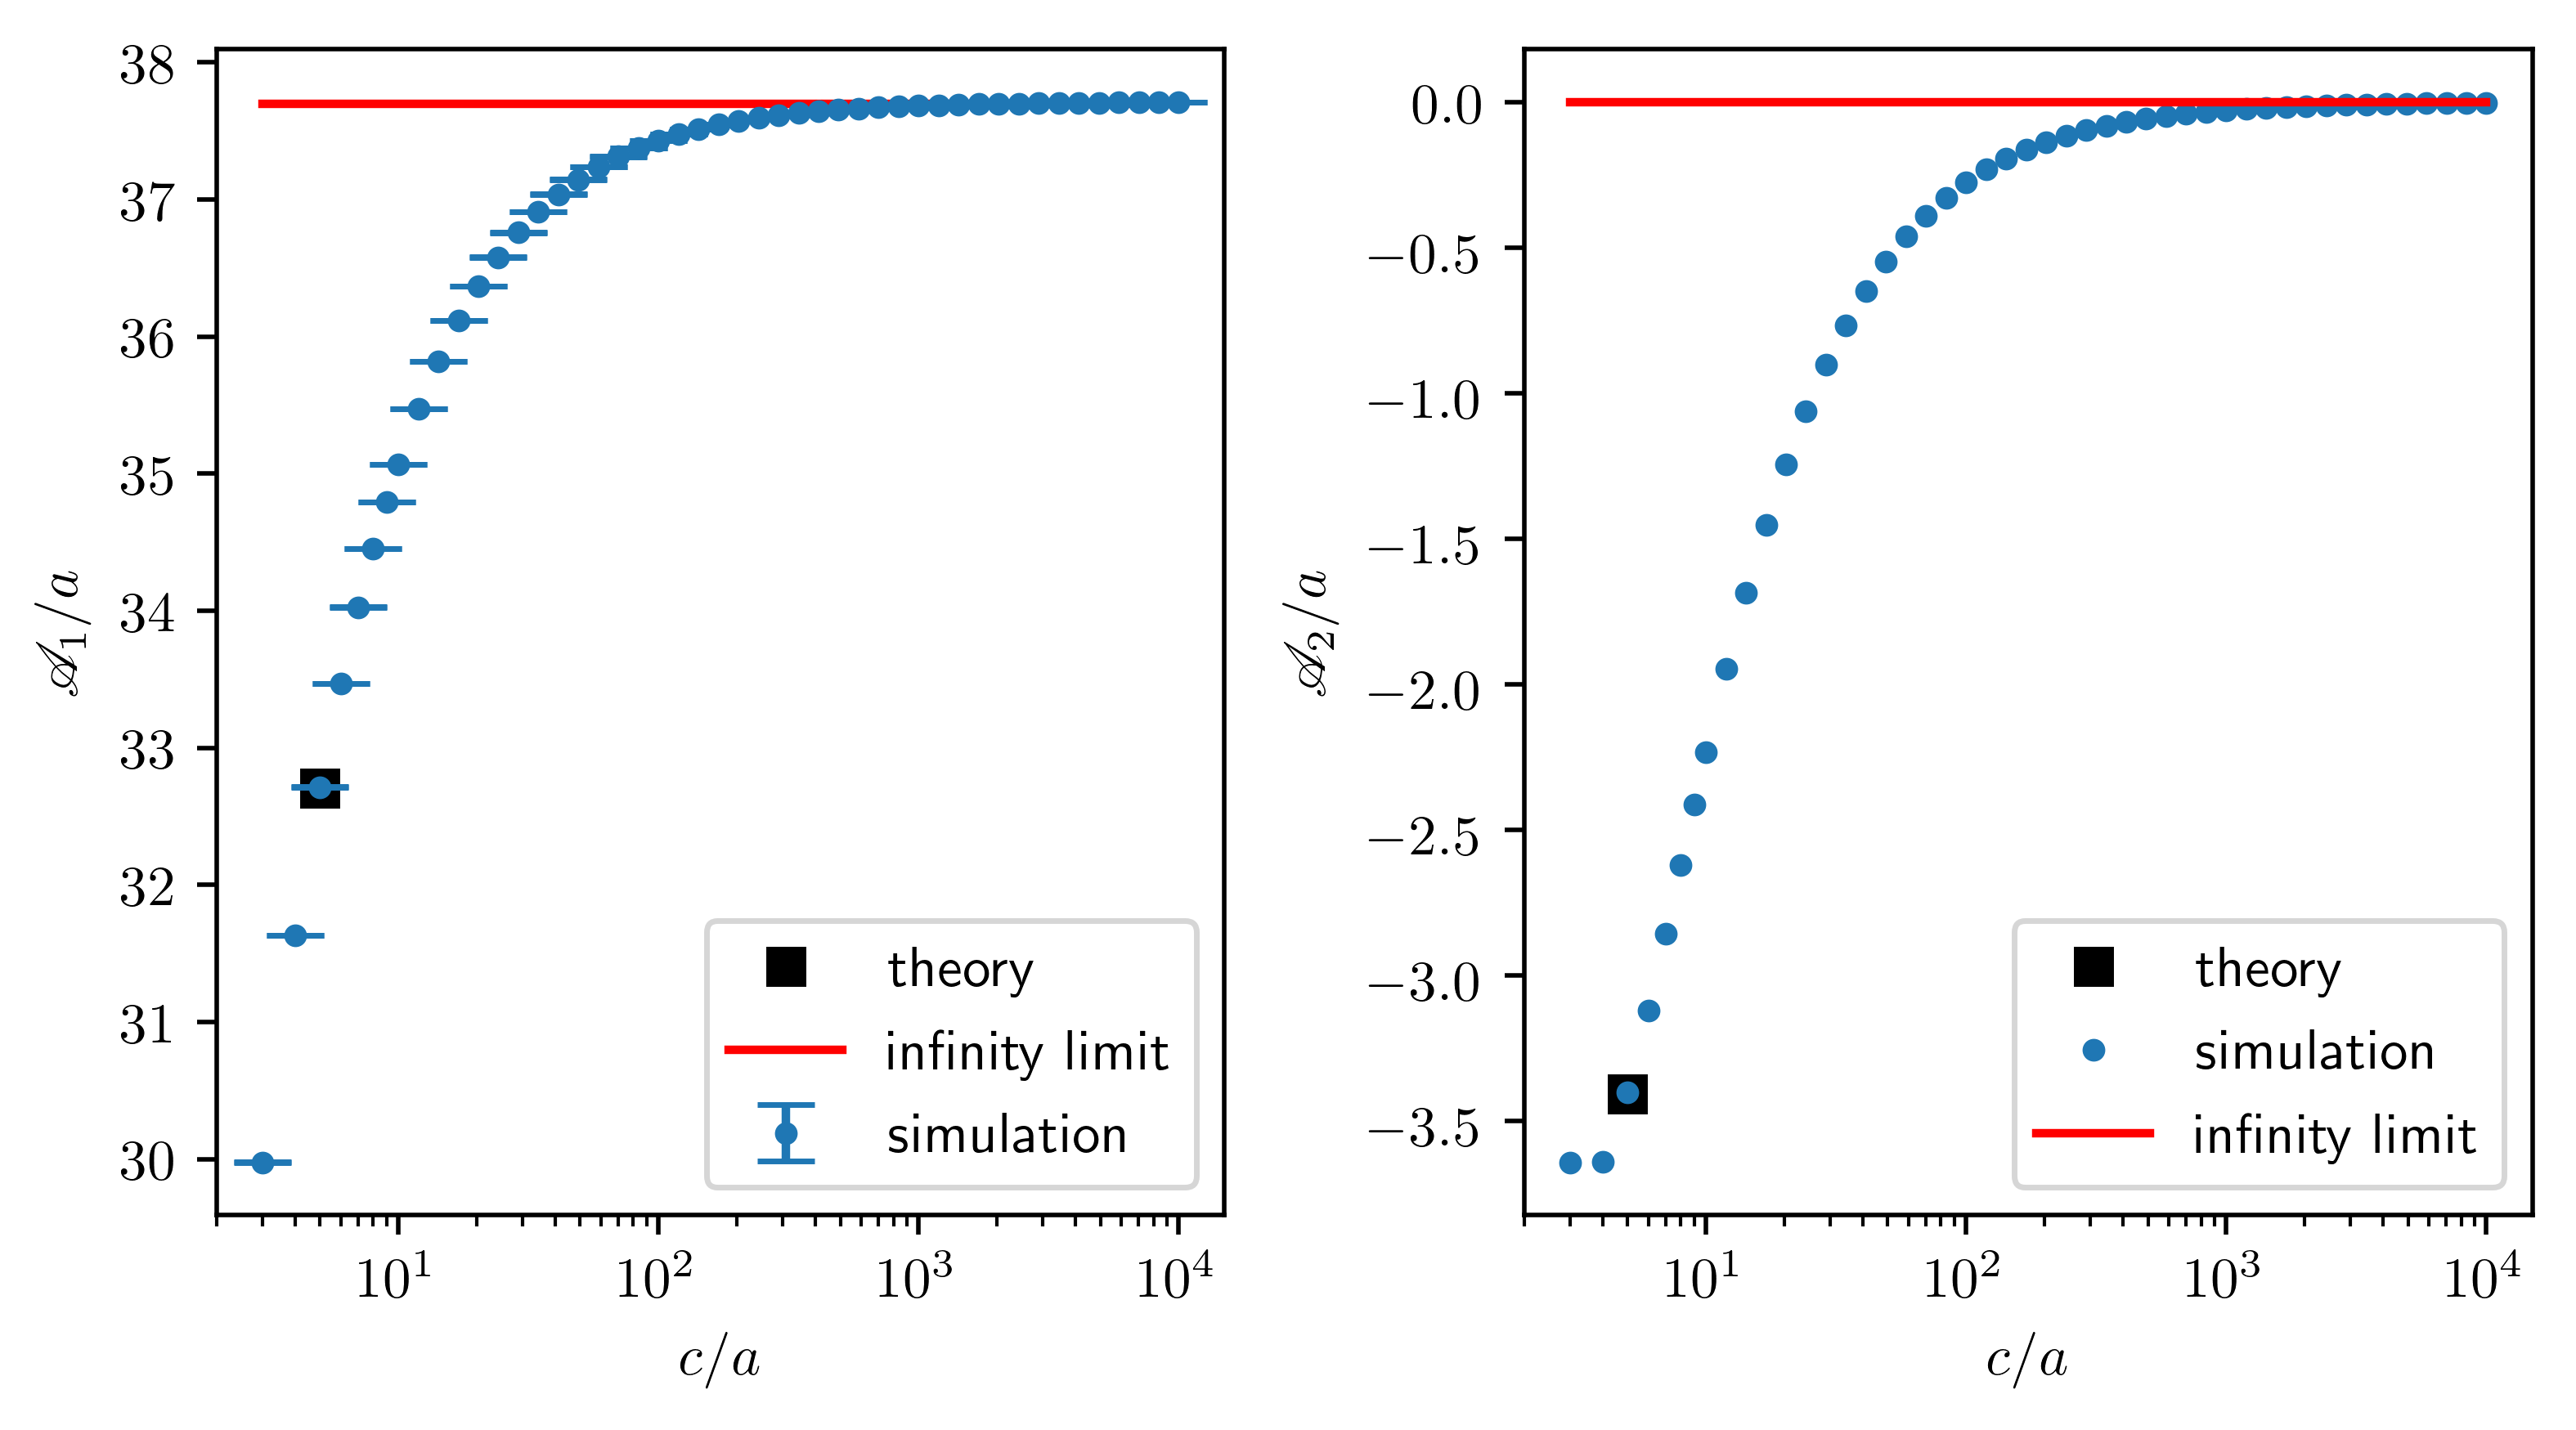

In [14]:
%matplotlib inline
# job_dir = 'dumbAtBtCt_1'
job_dir = 'dumbAtBtCt_2'
figsize = np.array((16, 9)) * 0.4
dpi = 500

problem_kwarg_list, At_list, Bt1_list, Bt2_list, Ct_list = load_AtBtCt(job_dir)
dumb_d_list = np.array([problem_kwarg['dumb_d'] for problem_kwarg in problem_kwarg_list])
A1_mean = np.array([np.mean([At[0,0], At[1,1]]) for At in At_list])
A1_std = np.array([np.std([At[0,0], At[1,1]]) for At in At_list])
A2_list = np.array([At[2,2] - np.mean([At[0,0], At[1,1]]) for At in At_list])
tidx = np.argsort(dumb_d_list)

fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi = axs[0]
axi.plot(5, 32.7024, 'sk', label='theory')
axi.plot(dumb_d_list[tidx], np.ones_like(dumb_d_list) * 6 * np.pi * 2, '-r', label='infinity limit')
axi.errorbar(dumb_d_list[tidx], A1_mean[tidx], yerr=A1_std[tidx], fmt='.', 
             capsize=5, label='simulation')
axi.set_xscale('log')
# axi.set_yscale('log')
# axi.set_xlabel('$d_d$')
axi.set_xlabel('$c/a$')
axi.set_ylabel('$\mathscr{A}_1 / a$')
axi.legend()

axi = axs[1]
axi.plot(5, -3.4085, 'sk', label='theory')
axi.plot(dumb_d_list[tidx], A2_list[tidx], '.', label='simulation')
axi.plot(dumb_d_list[tidx], np.zeros_like(dumb_d_list), '-r', label='infinity limit')
axi.set_xscale('log')
# axi.set_xlabel('$d_d$')
axi.set_xlabel('$c/a$')
axi.set_ylabel('$\mathscr{A}_2 / a$')
axi.legend()

plt.tight_layout()

## Eq 21 in Darci2020, vary helicoid_r and dumb_theta at the same time

In [30]:
%matplotlib inline
# job_dir = 'twoArmPropeller_1'
job_dir = 'twoArmPropeller_2'
min_helicoid_r = 0

problem_kwarg_list, At_list, Bt1_list, Bt2_list, Ct_list = load_AtBtCt(job_dir)
helicoid_r_list = np.array([problem_kwarg['helicoid_r'] for problem_kwarg in problem_kwarg_list])
dumb_theta_list = np.array([problem_kwarg['dumb_theta'] for problem_kwarg in problem_kwarg_list])
TrB1_list = np.array([np.trace(Bt1) for Bt1 in Bt1_list])
TrB2_list = np.array([np.trace(Bt2) for Bt2 in Bt2_list])

tidx = helicoid_r_list >= min_helicoid_r
data_dumb = pd.DataFrame({'TrB1': TrB1_list[tidx], 
                          'TrB2': TrB2_list[tidx], 
                          'dumb_theta': dumb_theta_list[tidx], 
                          'helicoid_r': helicoid_r_list[tidx], 
                         }).pivot_table(index=['dumb_theta'], columns=['helicoid_r'], )


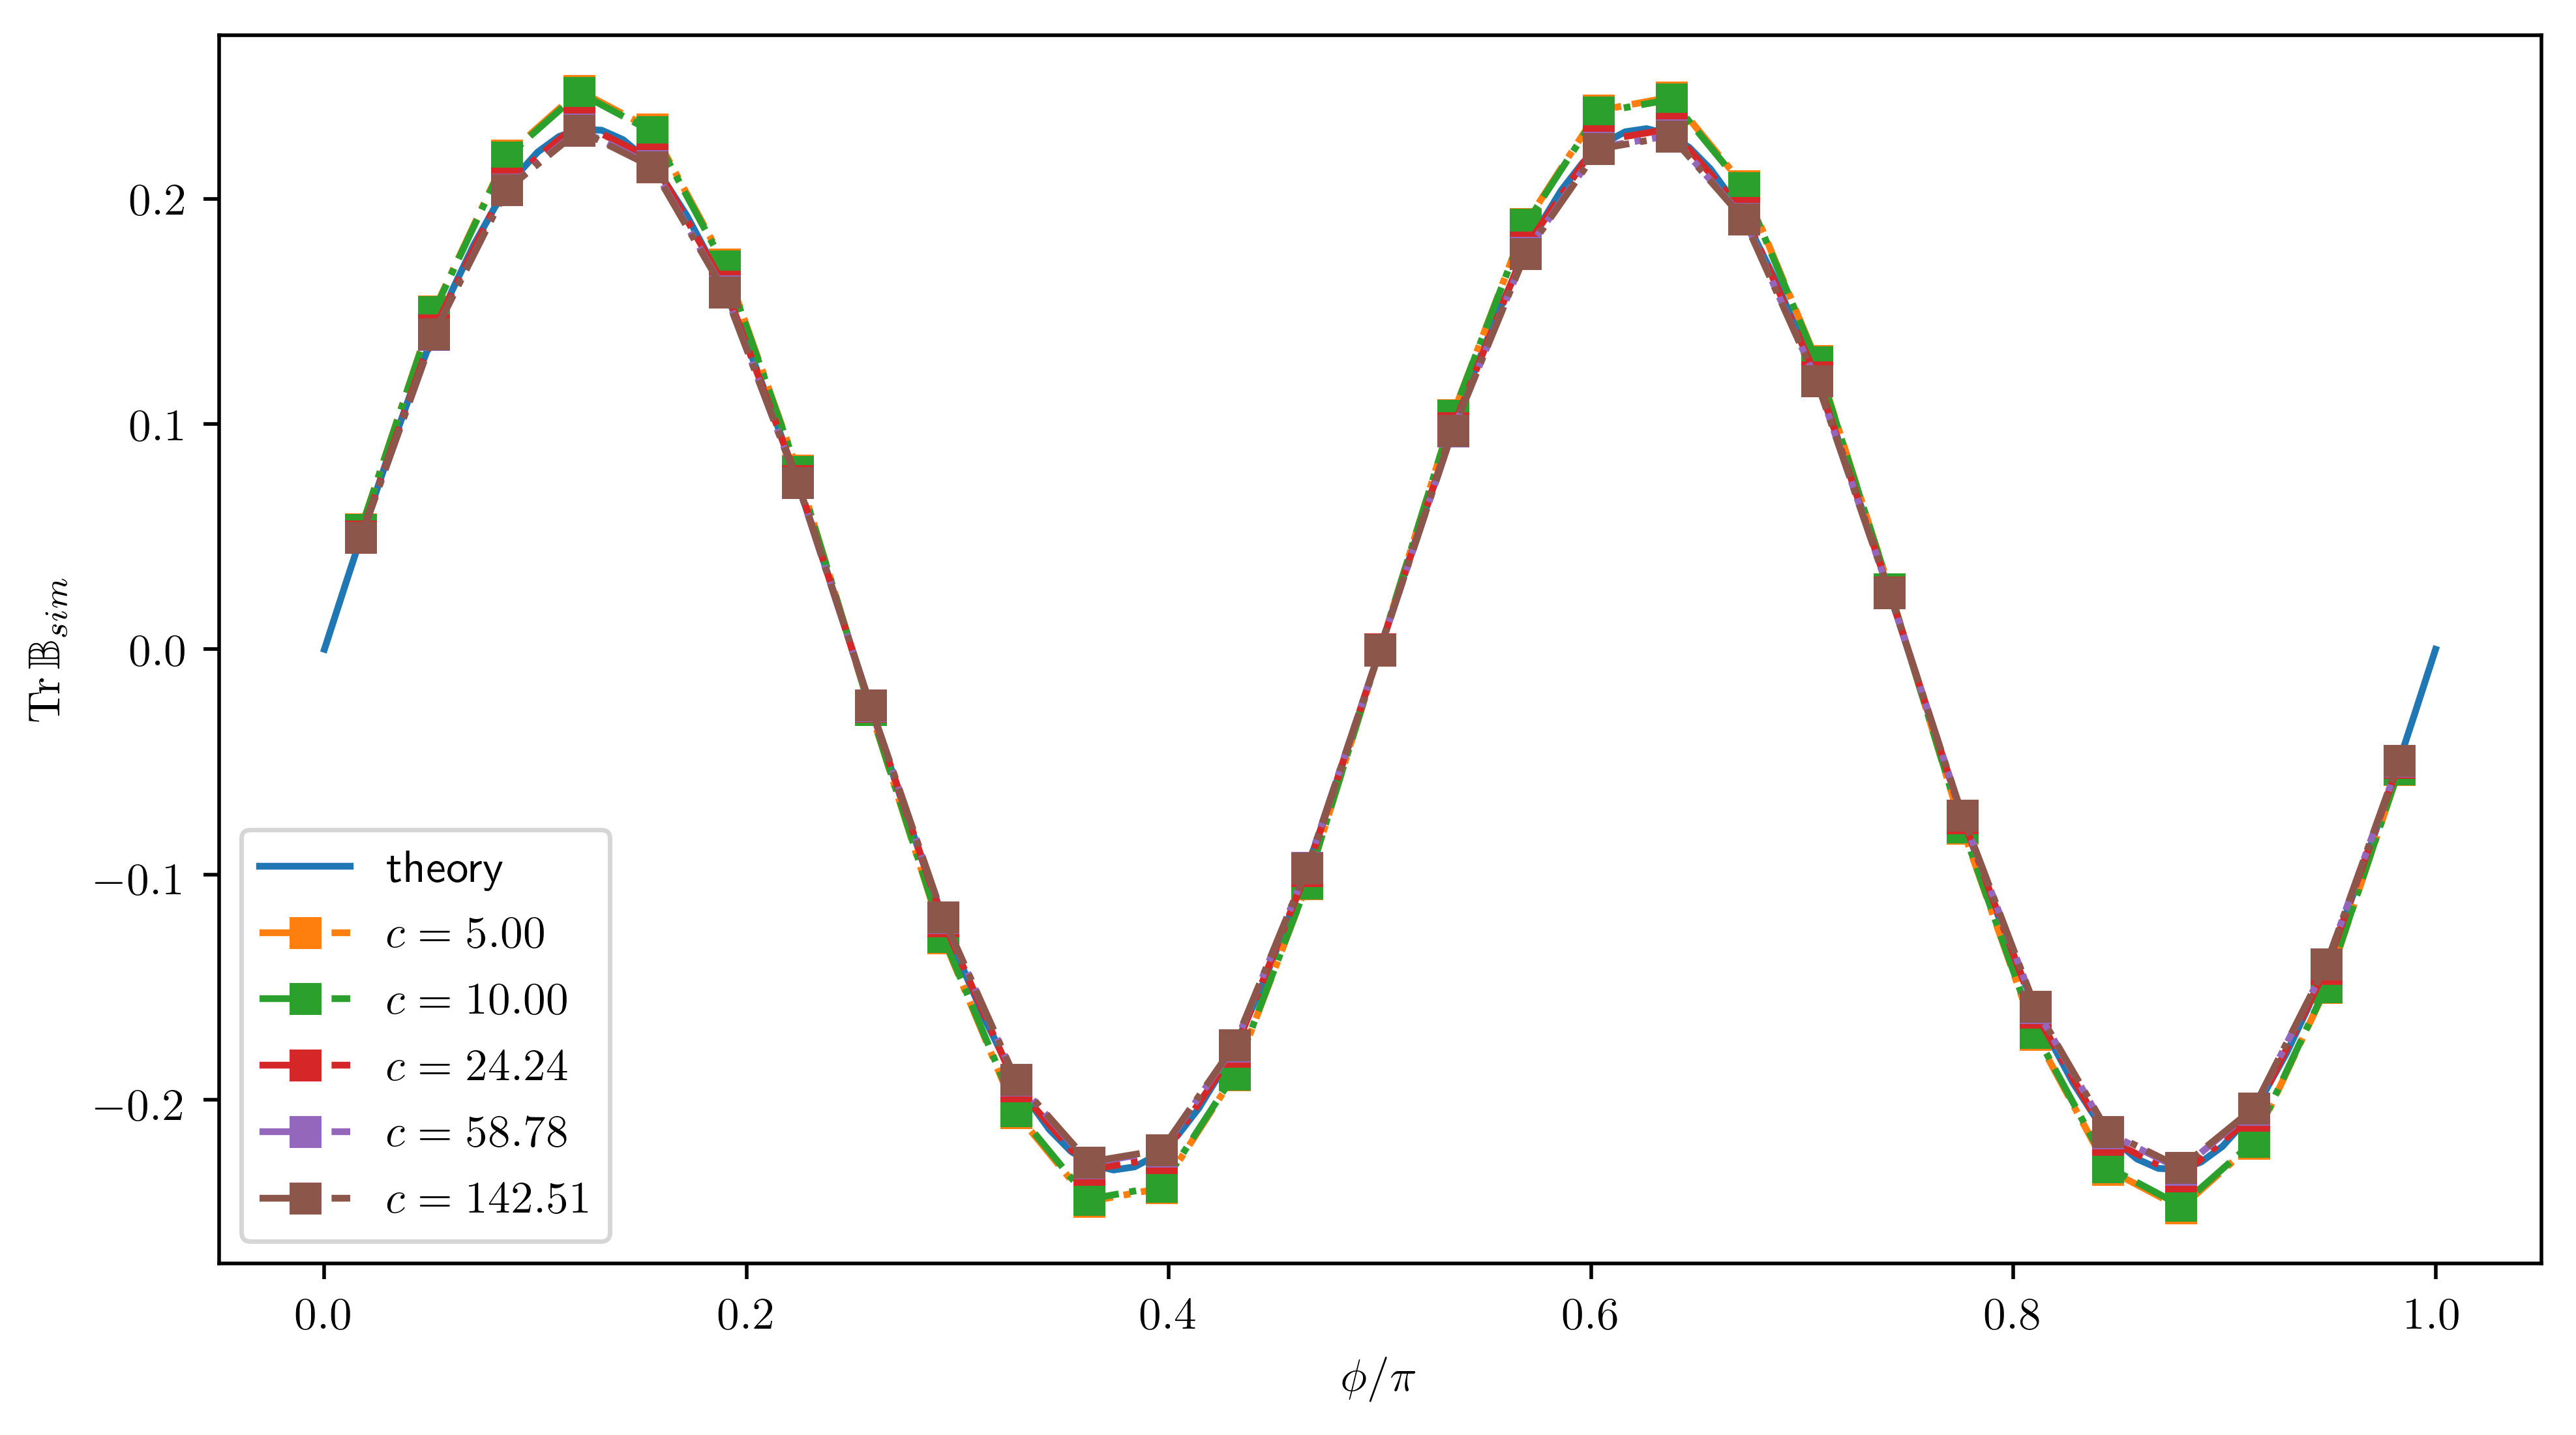

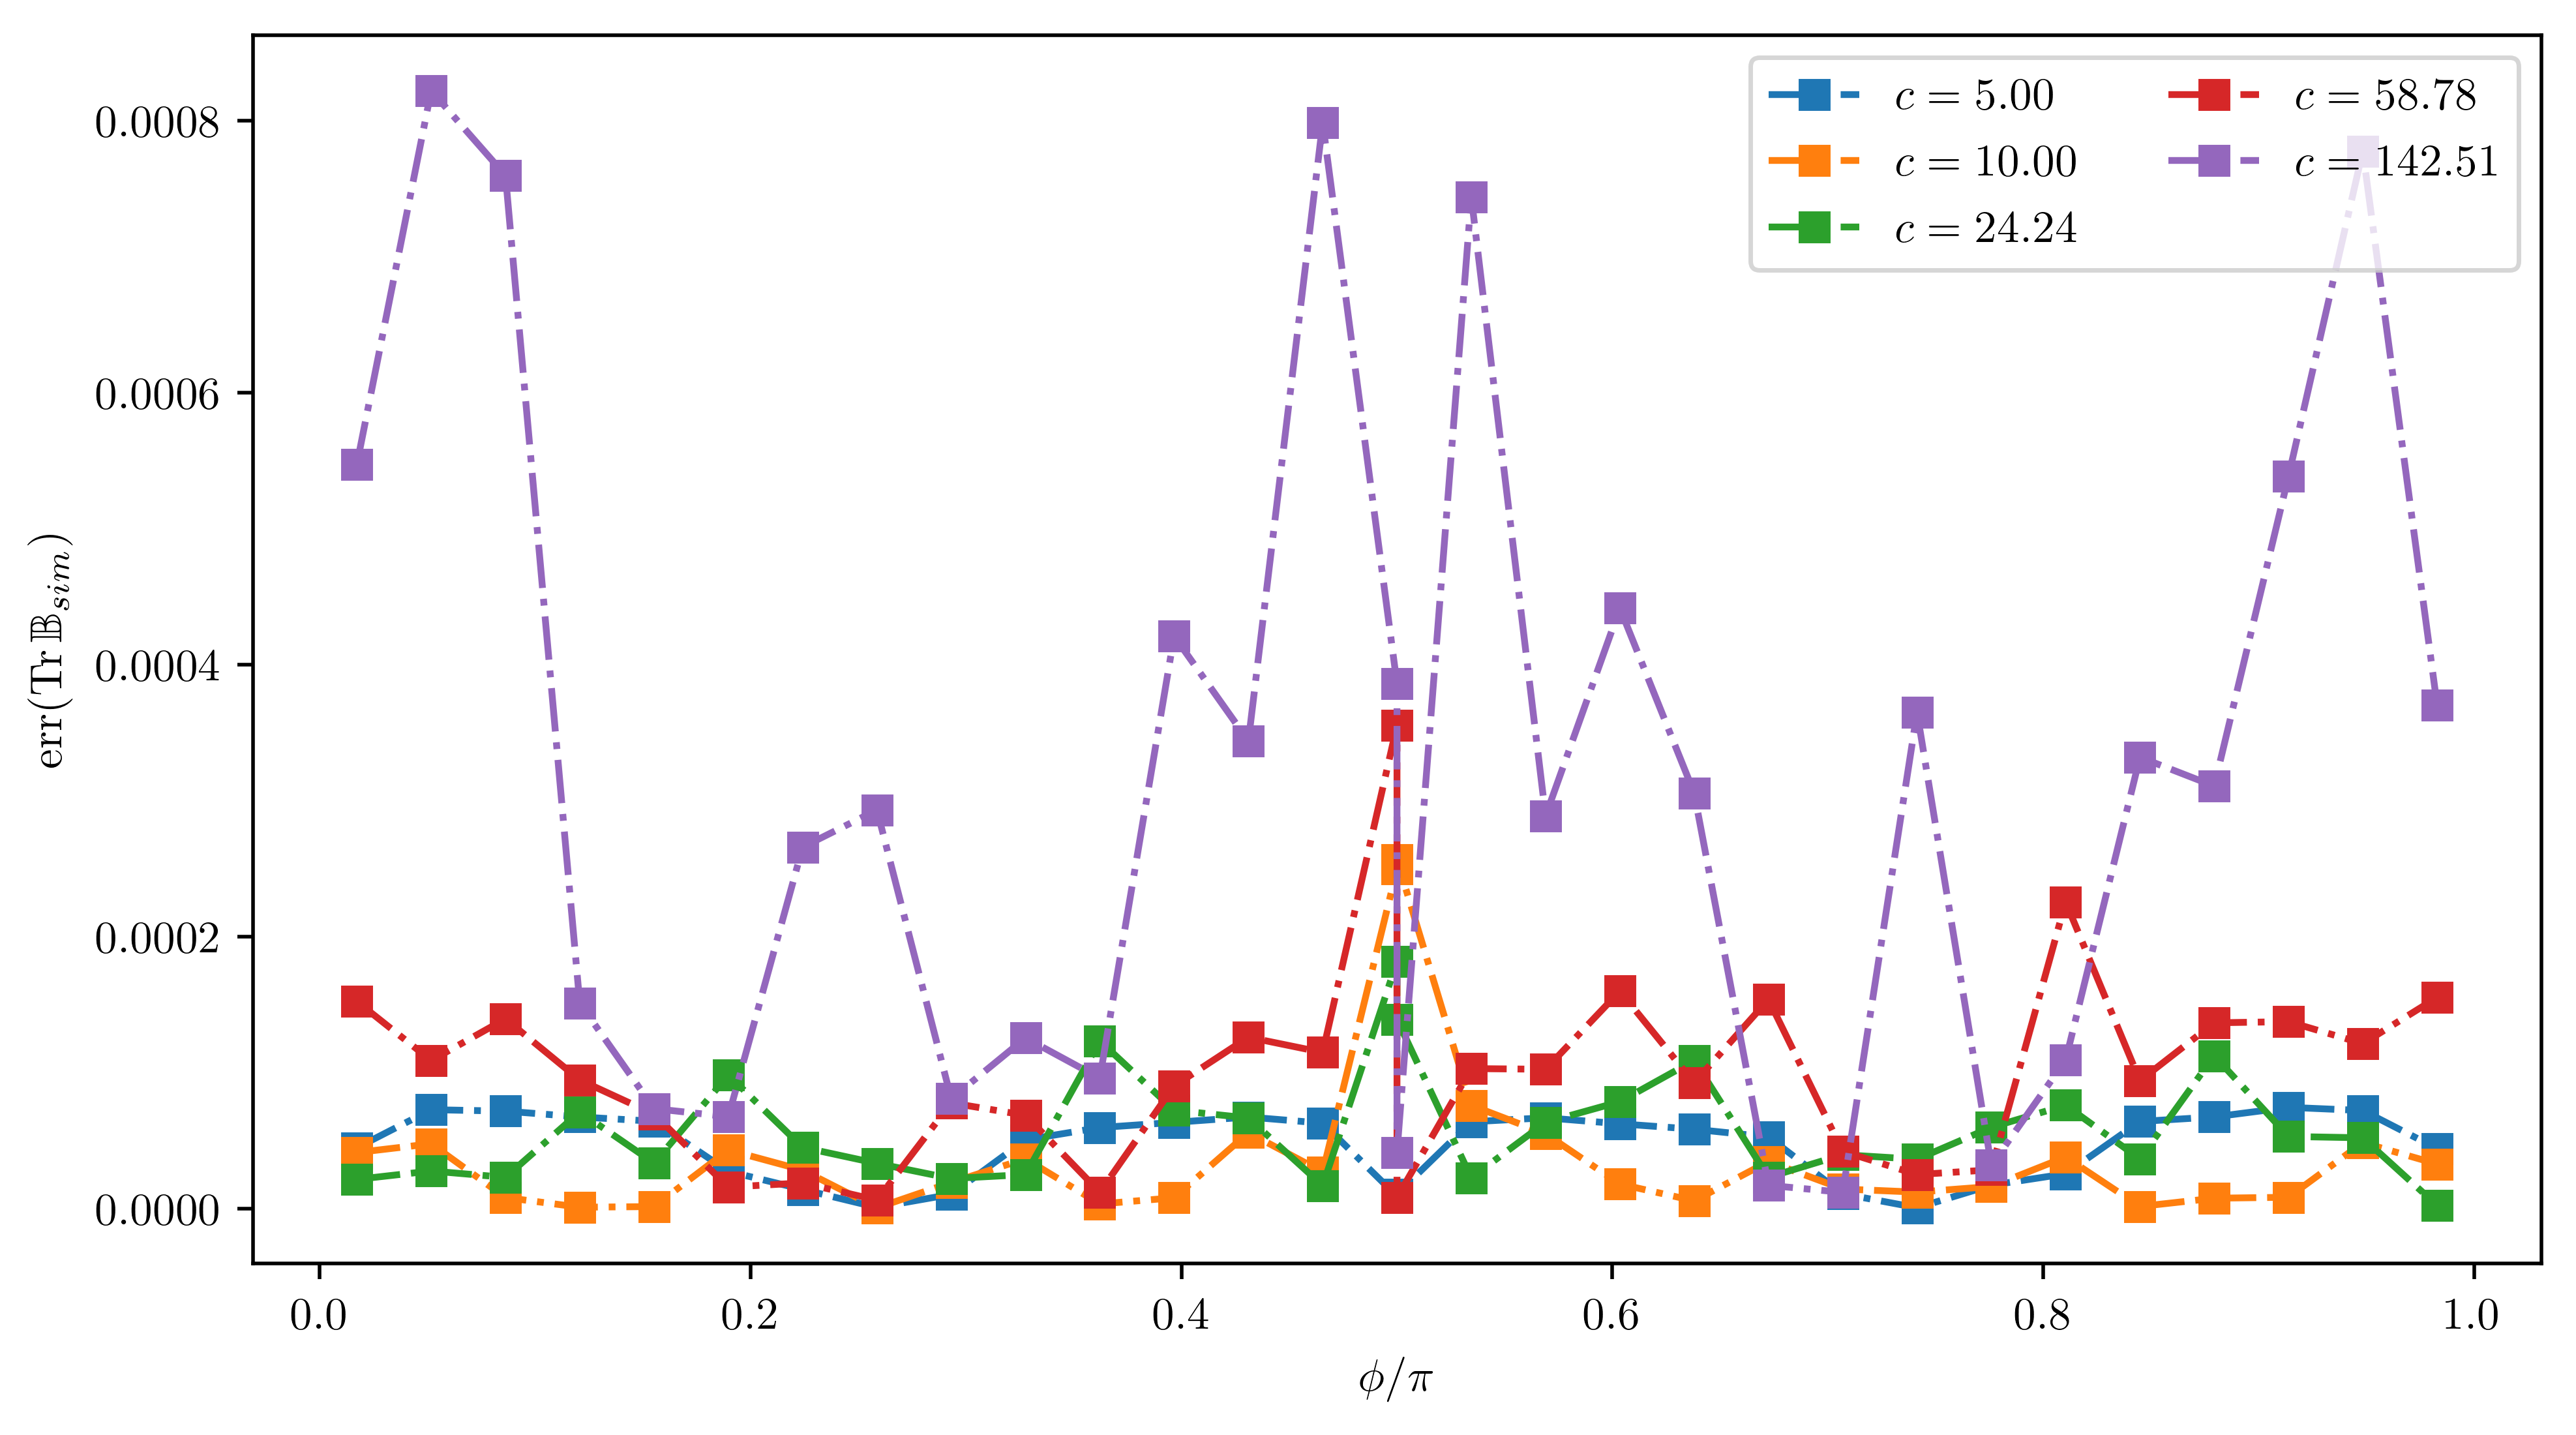

In [34]:
dumb_r = 1
phi = np.linspace(0, np.pi, 100)
A2 = -3.4085 * dumb_r
figsize = np.array((16, 9)) * 0.5
dpi = 500
useTrB = data_dumb.TrB2
plt_r_idx = [0, 5, 10, 15, 20]

# phi_darci = (-phi + np.pi / 2) % np.pi
phi_darci = phi
TrB_darci = (A2 ** 2 * np.sin(4 * phi_darci)) / (16 * np.pi)
ri_list = useTrB.columns.values

# TrB, simulation vs theory
fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi.plot(phi_darci / np.pi, TrB_darci, label='theory')
for ri in ri_list[plt_r_idx]:
    tTrB = useTrB[ri]
    dumb_theta_list = tTrB.index.values
    dumb_theta_list_darci = (dumb_theta_list + np.pi / 2) % np.pi
#     dumb_theta_list_darci = dumb_theta_list
    tidx = np.argsort(dumb_theta_list_darci)
    ty = tTrB.values
    axi.plot(dumb_theta_list_darci[tidx] / np.pi, ty[tidx], '-.s', label='$c=%.2f$' % ri)
axi.legend(ncol=1, loc='lower left')
axi.set_xlabel('$\\phi / \\pi$')
axi.set_ylabel('$\\Tr \\mathbb{B}_{sim}$')
plt.tight_layout()

# abs err of TrB
fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
for ri in ri_list[plt_r_idx]:
    tTrB1 = data_dumb.TrB1[ri]
    tTrB2 = data_dumb.TrB2[ri]
    errTrB = np.abs(tTrB1 - tTrB2)
    dumb_theta_list = errTrB.index.values
    dumb_theta_list_darci = (dumb_theta_list + np.pi / 2) % np.pi
#     dumb_theta_list_darci = dumb_theta_list
    tidx = np.argsort(dumb_theta_list_darci)
    ty = errTrB.values
    axi.plot(dumb_theta_list_darci[tidx] / np.pi, ty[tidx], '-.s', label='$c=%.2f$' % ri)
axi.legend(ncol=2, loc='upper right')
axi.set_xlabel('$\\phi / \\pi$')
axi.set_ylabel('$\operatorname{err}(\\Tr \\mathbb{B}_{sim})$')
plt.tight_layout()


In [28]:
plt_r_idx = [0, 5, 10, 15, 20]
ri_list[plt_r_idx]

array([ 5.,  6.,  7.,  8.,  9., 10.])

## dumbell helicoid with sphere at center

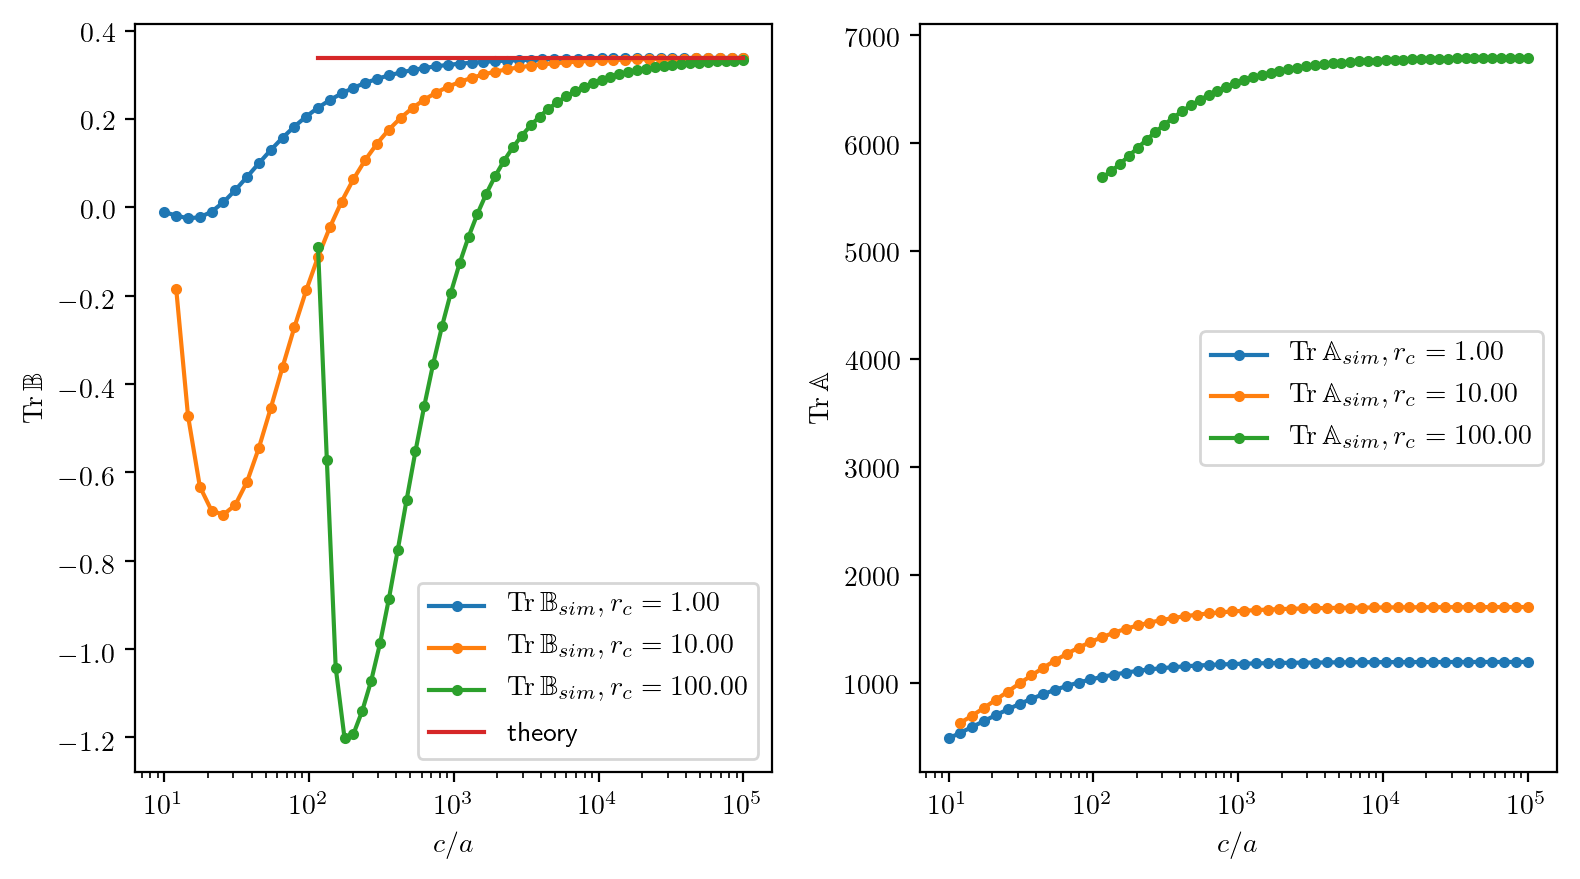

In [58]:
%matplotlib inline
# job_dir = 'helicoid_dumb_sphere_rcs0001'
# # job_dir = 'helicoid_dumb_sphere_rcs0010'
# # job_dir = 'helicoid_dumb_sphere_rcs0100'

job_dir_list = ['helicoid_dumb_sphere_rcs0001', 
                'helicoid_dumb_sphere_rcs0010', 
                'helicoid_dumb_sphere_rcs0100', 
               ]
min_helicoid_r, max_helicoid_r = 0, 10 ** 5
figsize = np.array((16, 9)) * 0.5
dpi = 200
theory_Darci2020 = 0.3375

fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')

for job_dir in job_dir_list:
    problem_kwarg_list, At_list, Bt1_list, Bt2_list, Ct_list = load_AtBtCt(job_dir)
    helicoid_r_list = np.array([problem_kwarg['helicoid_r'] for problem_kwarg in problem_kwarg_list])
    TrA_list = np.array([np.trace(At) for At in At_list])
    TrB1_list = np.array([np.trace(Bt1) for Bt1 in Bt1_list])
    TrB2_list = np.array([np.trace(Bt2) for Bt2 in Bt2_list])
    center_sphere_rs = problem_kwarg_list[0]['center_sphere_rs']
    tidx = (helicoid_r_list >= min_helicoid_r) * (helicoid_r_list <= max_helicoid_r)
    data_dumb = pd.DataFrame({'TrA': TrA_list[tidx], 
                              'TrB1': TrB1_list[tidx], 
                              'TrB2': TrB2_list[tidx], 
                              'helicoid_r': helicoid_r_list[tidx], 
                             }).pivot_table(index=['helicoid_r'])
    TrA = data_dumb.TrA
    TrB = data_dumb.TrB1
    
    axi = axs[0]
    tx = TrB.index.values
    ty = TrB.values
    axi.plot(tx, ty, '.-', 
             label='$\\Tr \\mathbb{B}_{sim}, r_c=%.2f$' % center_sphere_rs)
    axi = axs[1]
    tx = TrA.index.values
    ty = TrA.values
    axi.plot(tx, ty, '.-', label='$\\Tr \\mathbb{A}_{sim}, r_c=%.2f$' % center_sphere_rs)
    
axi = axs[0]
axi.plot(tx, theory_Darci2020 * np.ones_like(ty), '-', label='theory')
axi.set_xscale('log')
axi.legend()
axi.set_xlabel('$c/a$')
axi.set_ylabel('$\\Tr \mathbb{B}$')
axi = axs[1]
axi.set_xscale('log')
axi.legend()
axi.set_xlabel('$c/a$')
axi.set_ylabel('$\\Tr \mathbb{A}$')
plt.tight_layout()

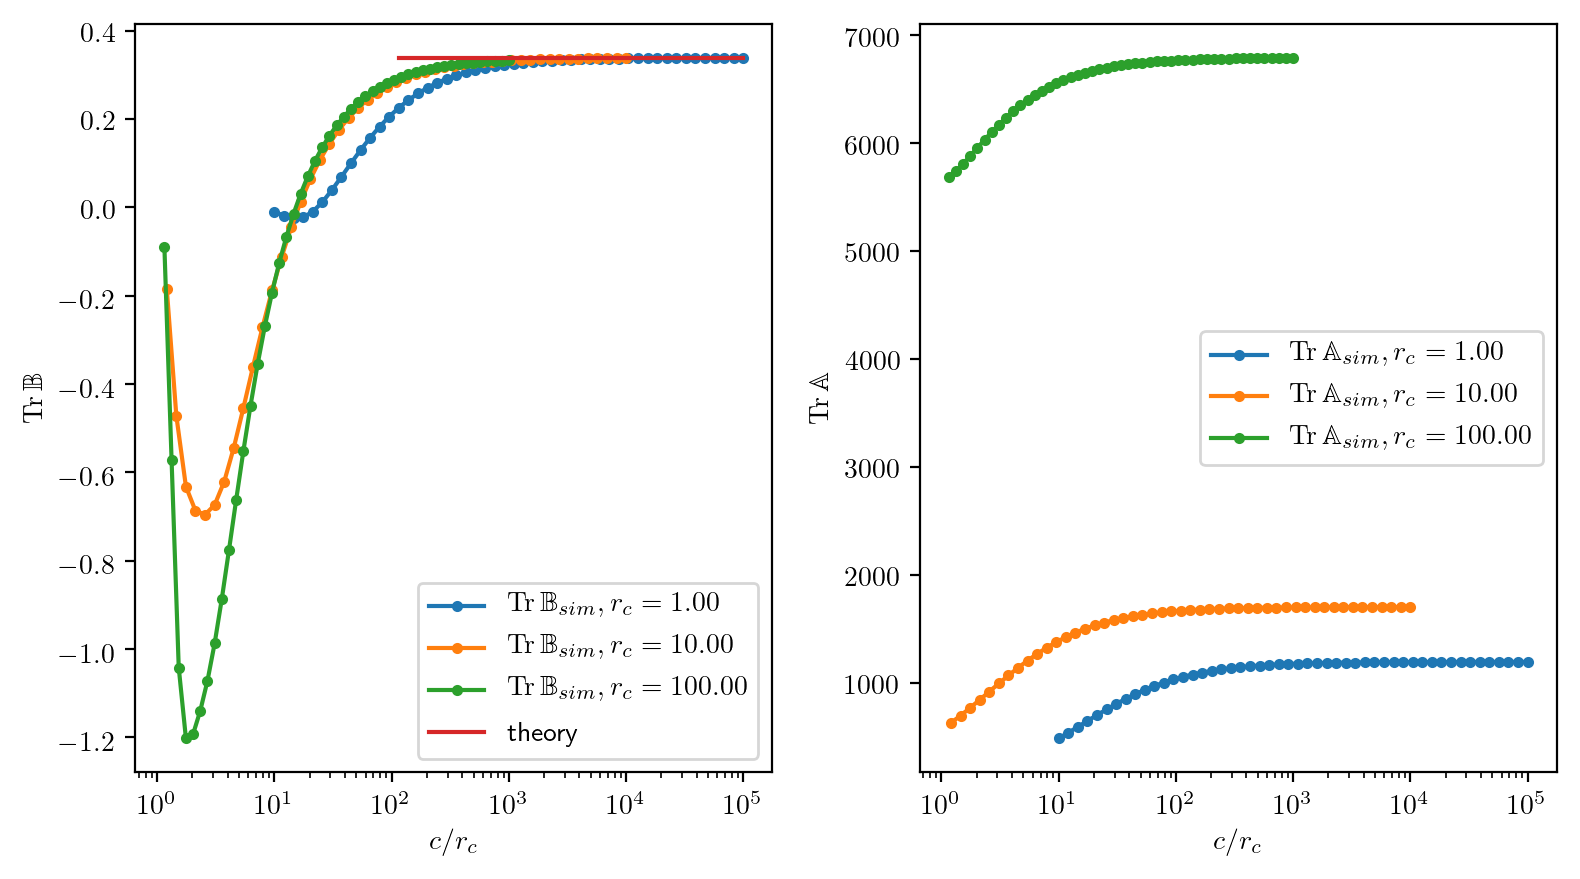

In [59]:
%matplotlib inline
# job_dir = 'helicoid_dumb_sphere_rcs0001'
# # job_dir = 'helicoid_dumb_sphere_rcs0010'
# # job_dir = 'helicoid_dumb_sphere_rcs0100'

job_dir_list = ['helicoid_dumb_sphere_rcs0001', 
                'helicoid_dumb_sphere_rcs0010', 
                'helicoid_dumb_sphere_rcs0100', 
               ]
min_helicoid_r, max_helicoid_r = 0, 10 ** 5
figsize = np.array((16, 9)) * 0.5
dpi = 800
theory_Darci2020 = 0.3375

fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')

for job_dir in job_dir_list:
    problem_kwarg_list, At_list, Bt1_list, Bt2_list, Ct_list = load_AtBtCt(job_dir)
    helicoid_r_list = np.array([problem_kwarg['helicoid_r'] for problem_kwarg in problem_kwarg_list])
    TrA_list = np.array([np.trace(At) for At in At_list])
    TrB1_list = np.array([np.trace(Bt1) for Bt1 in Bt1_list])
    TrB2_list = np.array([np.trace(Bt2) for Bt2 in Bt2_list])
    center_sphere_rs = problem_kwarg_list[0]['center_sphere_rs']
    tidx = (helicoid_r_list >= min_helicoid_r) * (helicoid_r_list <= max_helicoid_r)
    data_dumb = pd.DataFrame({'TrA': TrA_list[tidx], 
                              'TrB1': TrB1_list[tidx], 
                              'TrB2': TrB2_list[tidx], 
                              'helicoid_r': helicoid_r_list[tidx], 
                             }).pivot_table(index=['helicoid_r'])
    TrA = data_dumb.TrA
    TrB = data_dumb.TrB1
    
    axi = axs[0]
    tx = TrB.index.values
    ty = TrB.values
    axi.plot(tx / center_sphere_rs, ty, '.-', 
             label='$\\Tr \\mathbb{B}_{sim}, r_c=%.2f$' % center_sphere_rs)
    axi = axs[1]
    tx = TrA.index.values
    ty = TrA.values
    axi.plot(tx / center_sphere_rs, ty, '.-', 
             label='$\\Tr \\mathbb{A}_{sim}, r_c=%.2f$' % center_sphere_rs)
    
axi = axs[0]
axi.plot(tx, theory_Darci2020 * np.ones_like(ty), '-', label='theory')
axi.set_xscale('log')
axi.legend()
axi.set_xlabel('$c/r_c$')
axi.set_ylabel('$\\Tr \mathbb{B}$')
axi = axs[1]
axi.set_xscale('log')
axi.legend()
axi.set_xlabel('$c/r_c$')
axi.set_ylabel('$\\Tr \mathbb{A}$')
plt.tight_layout()